<span style="color:blue; font-style:italic; font-size:30px;"># Sets Up</span>

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge, Circle
import geopandas as gpd
from shapely.geometry import Point
import datetime
import glob

In [2]:
dpi_ = 300

In [3]:
US = gpd.read_file('/N/project/Zli_lab/Data/Other/tl_2019_us_state/tl_2019_us_state.shp')
regions_dict = {
    'NE': ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT', 'WV'],
    'Midwest': ['IA', 'MI', 'MN', 'WI', 'IL', 'IN', 'MO', 'OH'],
    'SE': ['AL', 'FL', 'GA', 'NC', 'SC', 'VA', 'TN', 'KY', 'AR', 'LA', 'MS'],
    'NGP': ['MT', 'NE', 'ND', 'SD', 'WY'],
    'SGP': ['KS', 'OK', 'TX'],
    'SW': ['AZ', 'CO', 'NM', 'UT', 'CA', 'NV'],
    'NW': ['ID', 'OR', 'WA']
}
regions = {name: US[US['STUSPS'].isin(states)] for name, states in regions_dict.items()}

In [4]:
def crop_xarray_to_region(ds, region_gdf):
    lon2d, lat2d = np.meshgrid(ds['lon'].values, ds['lat'].values)
    
    points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(lon2d.flatten(), lat2d.flatten()),
        index=np.arange(lon2d.size),
        crs='EPSG:4326'
    )
    
    points_in_region = gpd.sjoin(points, region_gdf, how='inner', predicate='within')
    mask = np.full(lon2d.shape, False)
    for index in points_in_region.index:
        i, j = np.unravel_index(index, lon2d.shape)
        mask[i, j] = True

    mask_da = xr.DataArray(
        mask,
        dims=('lat', 'lon'),
        coords={'lat': ds['lat'], 'lon': ds['lon']}
    )
    
    ds_cropped = ds.where(mask_da, drop=True)
    return ds_cropped


## Mean/Maximum length of wet spell

In [5]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_MeLWS_MxLWS_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_MeLWS_MxLWS_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_MeLWS_MxLWS_U*')

In [6]:
ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

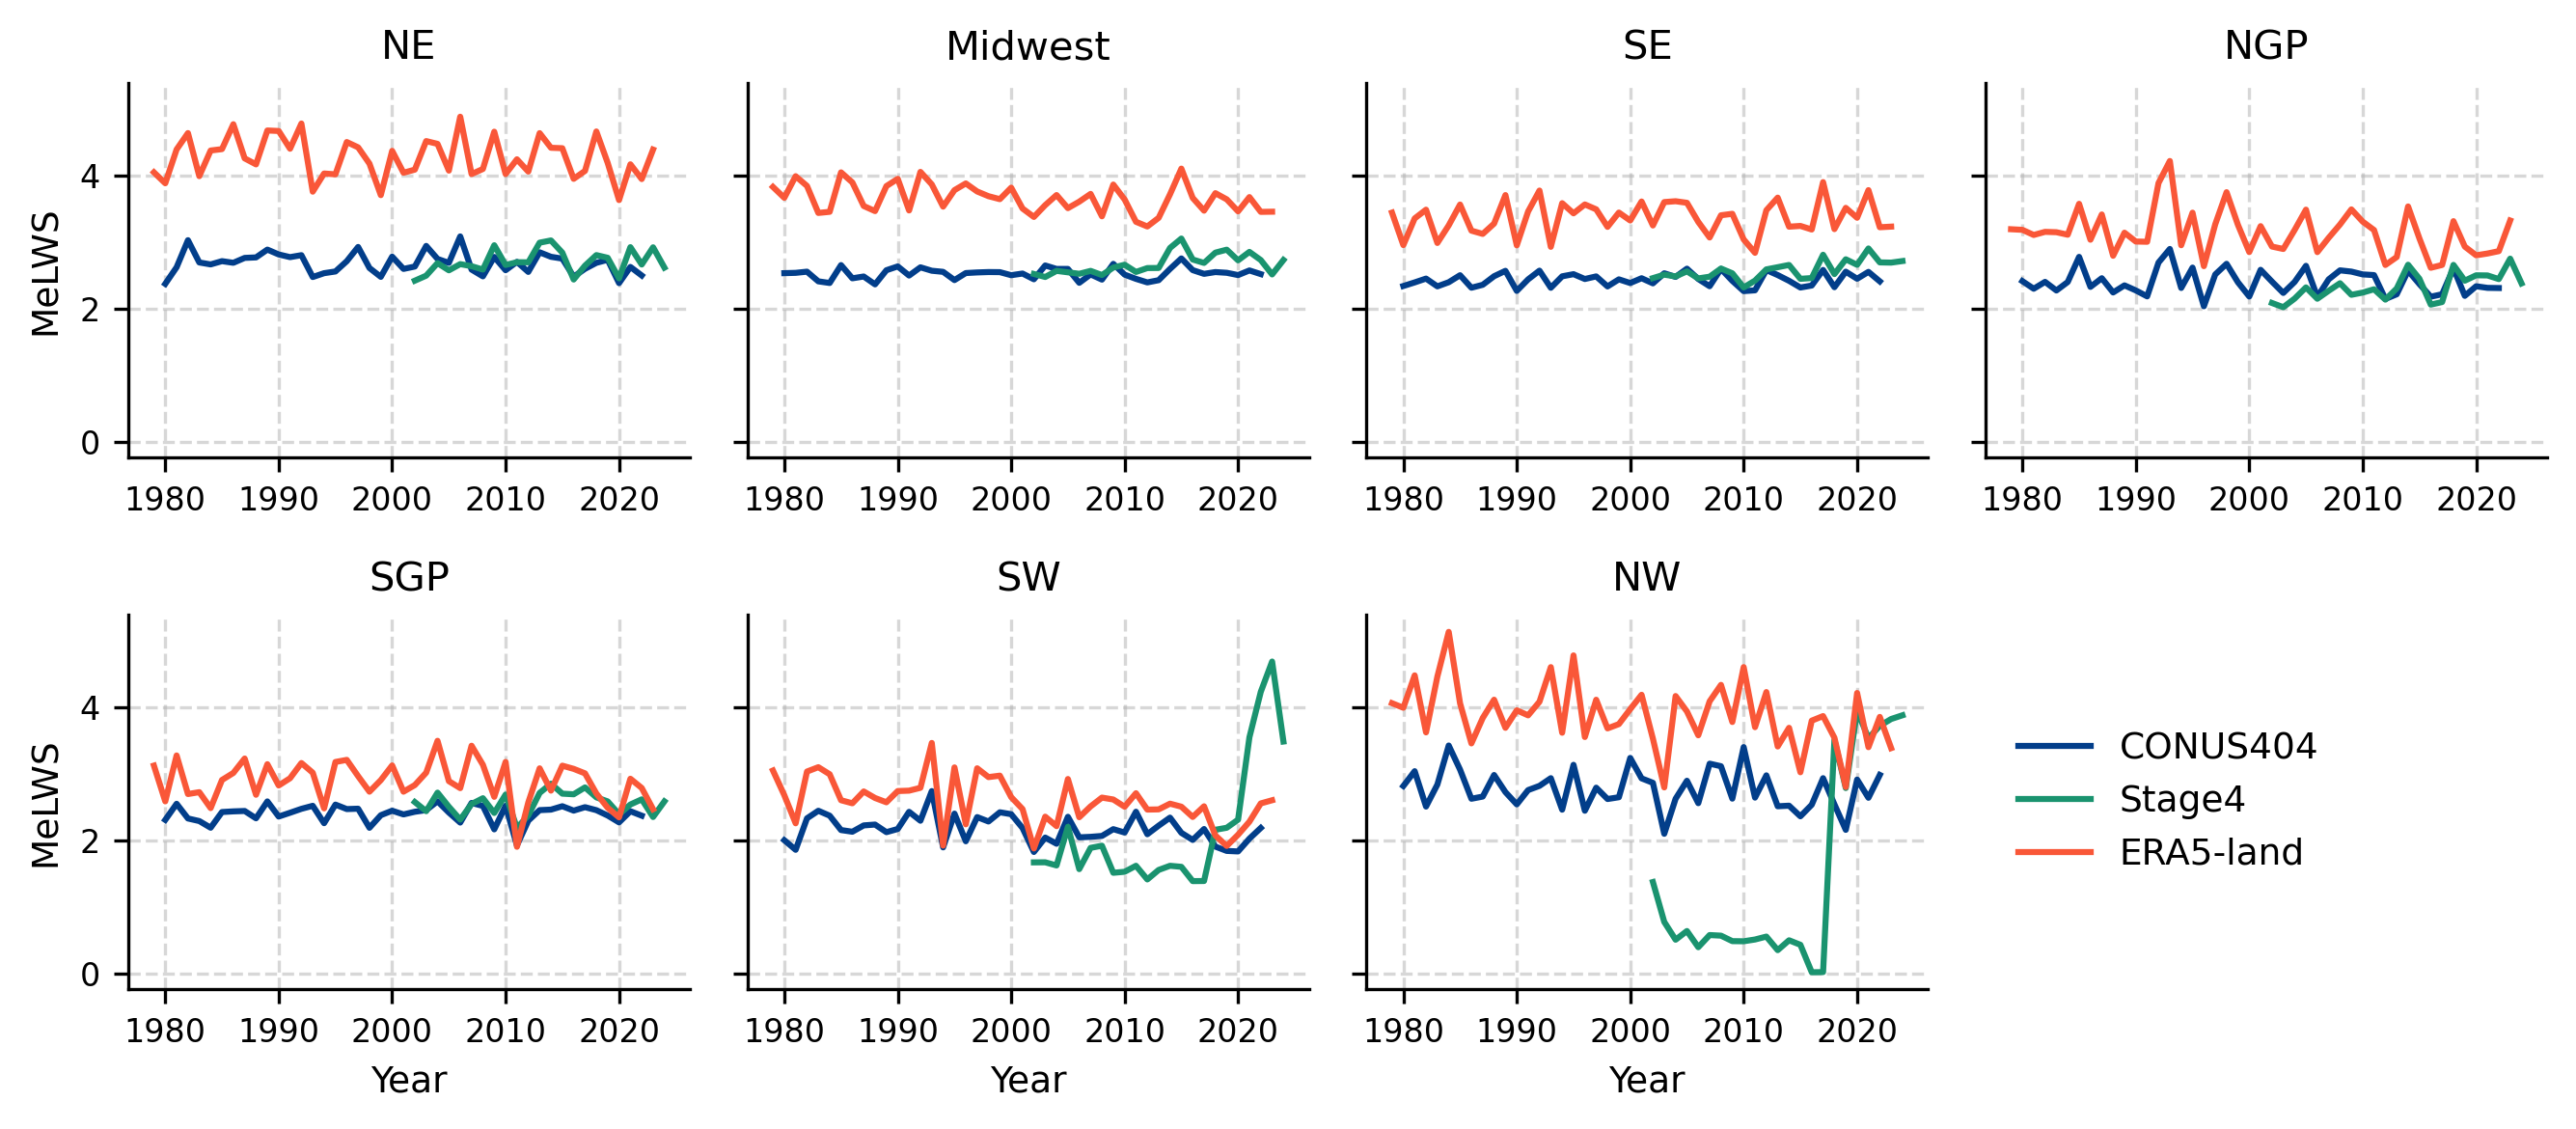

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['MeLWS'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('MeLWS', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

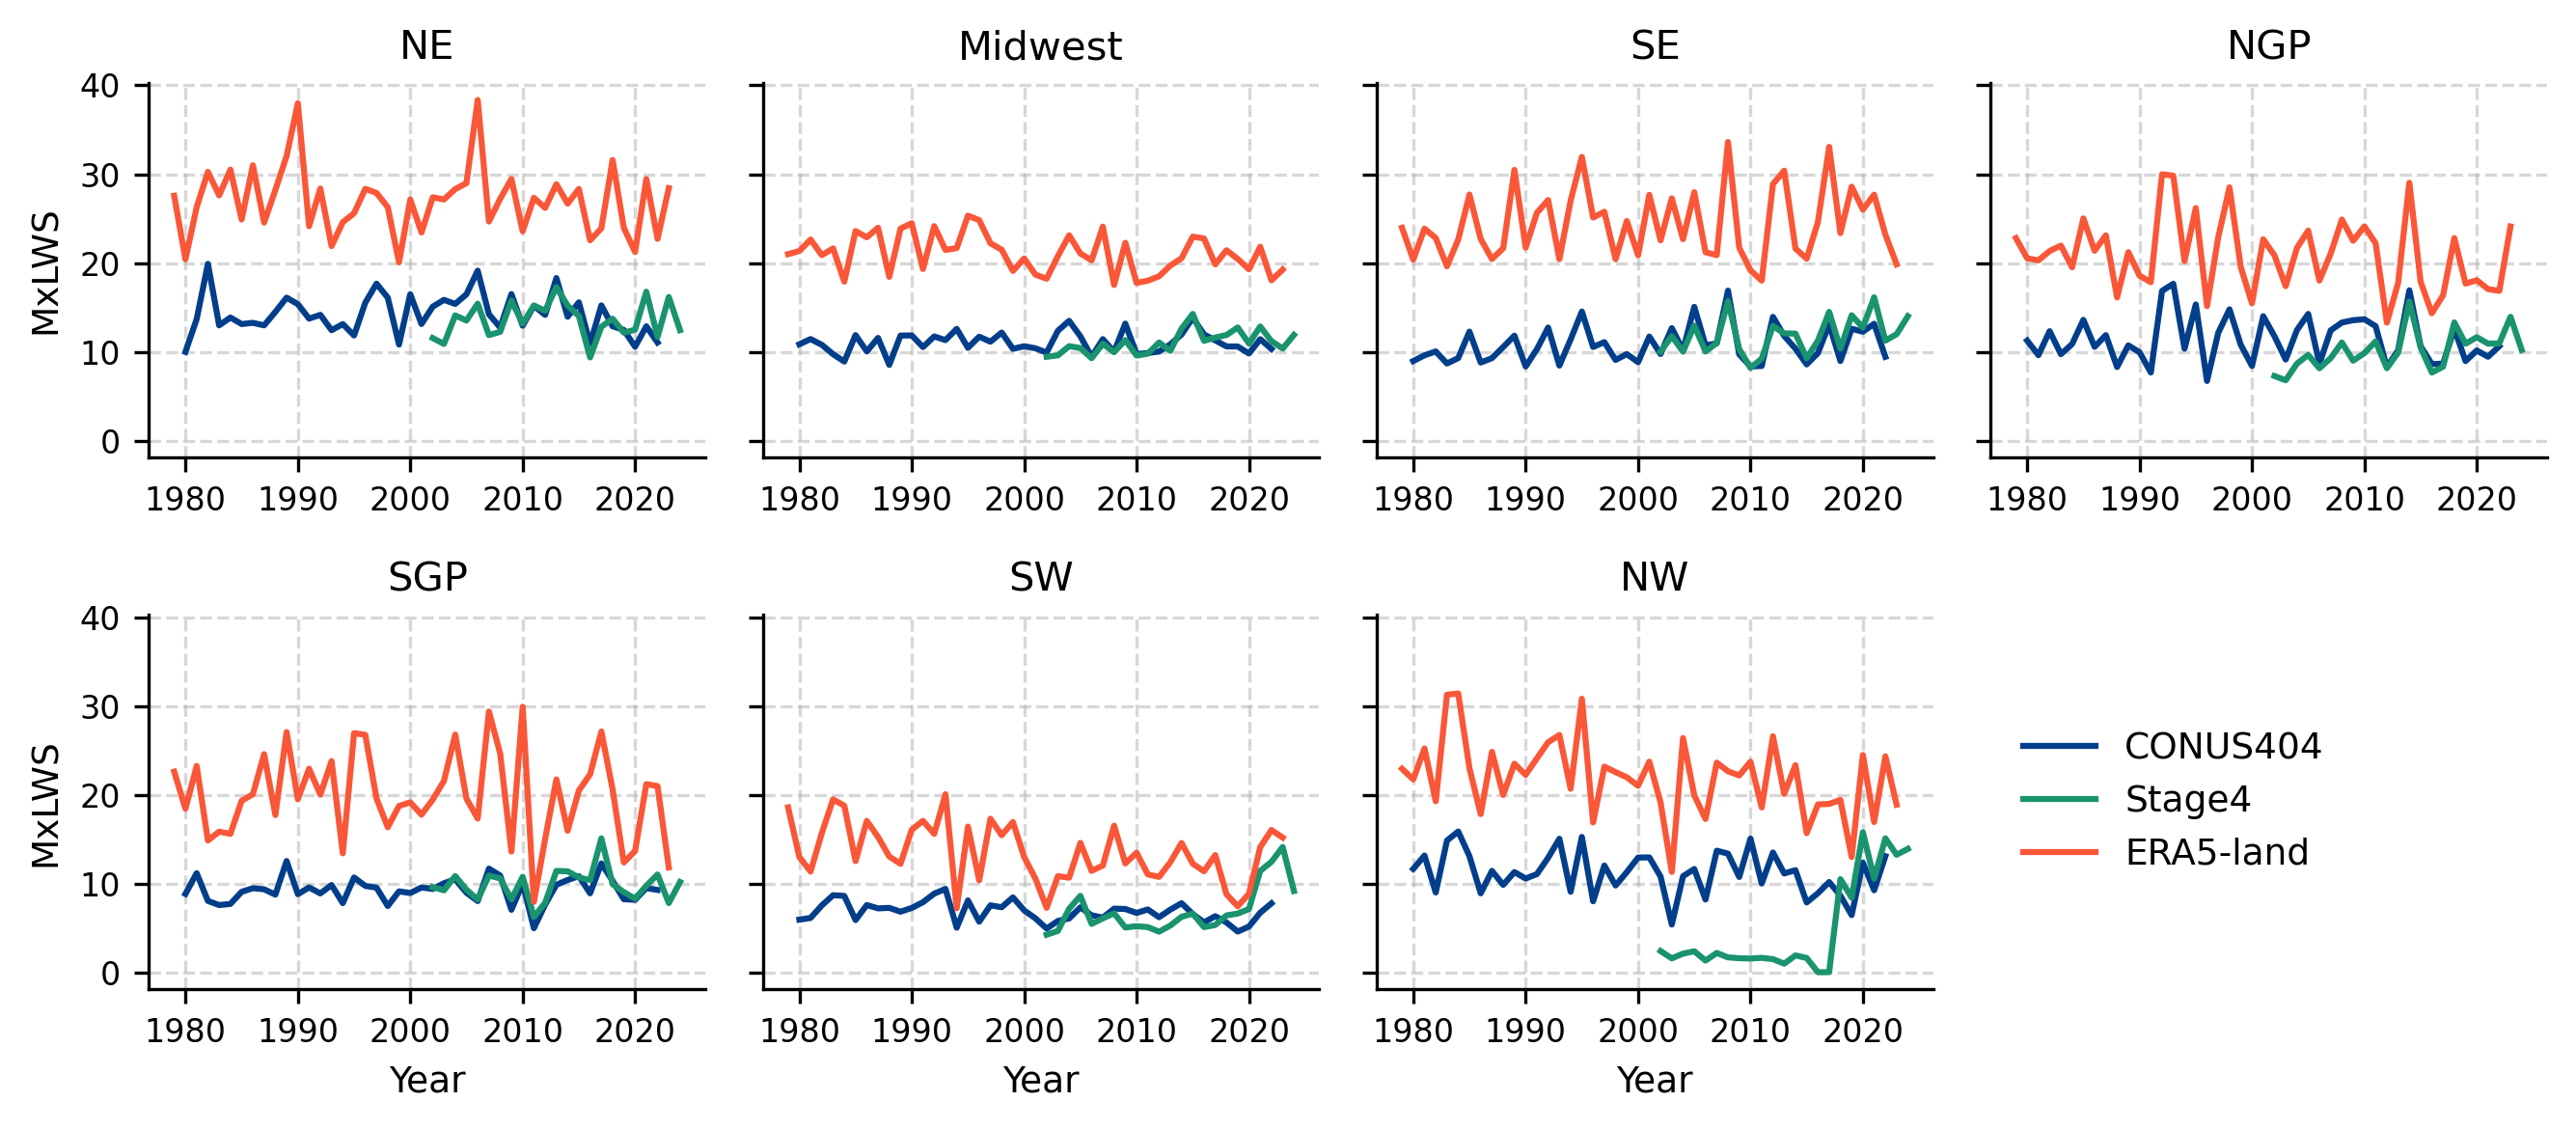

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['MxLWS'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('MxLWS', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

## annual maxima of H-hour (1-, 3-, 6-, 12- or 24-hour) precipitation series

In [9]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_RxHhr_1_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_RxHhr_1_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_RxHhr_1_U*')

In [10]:
ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

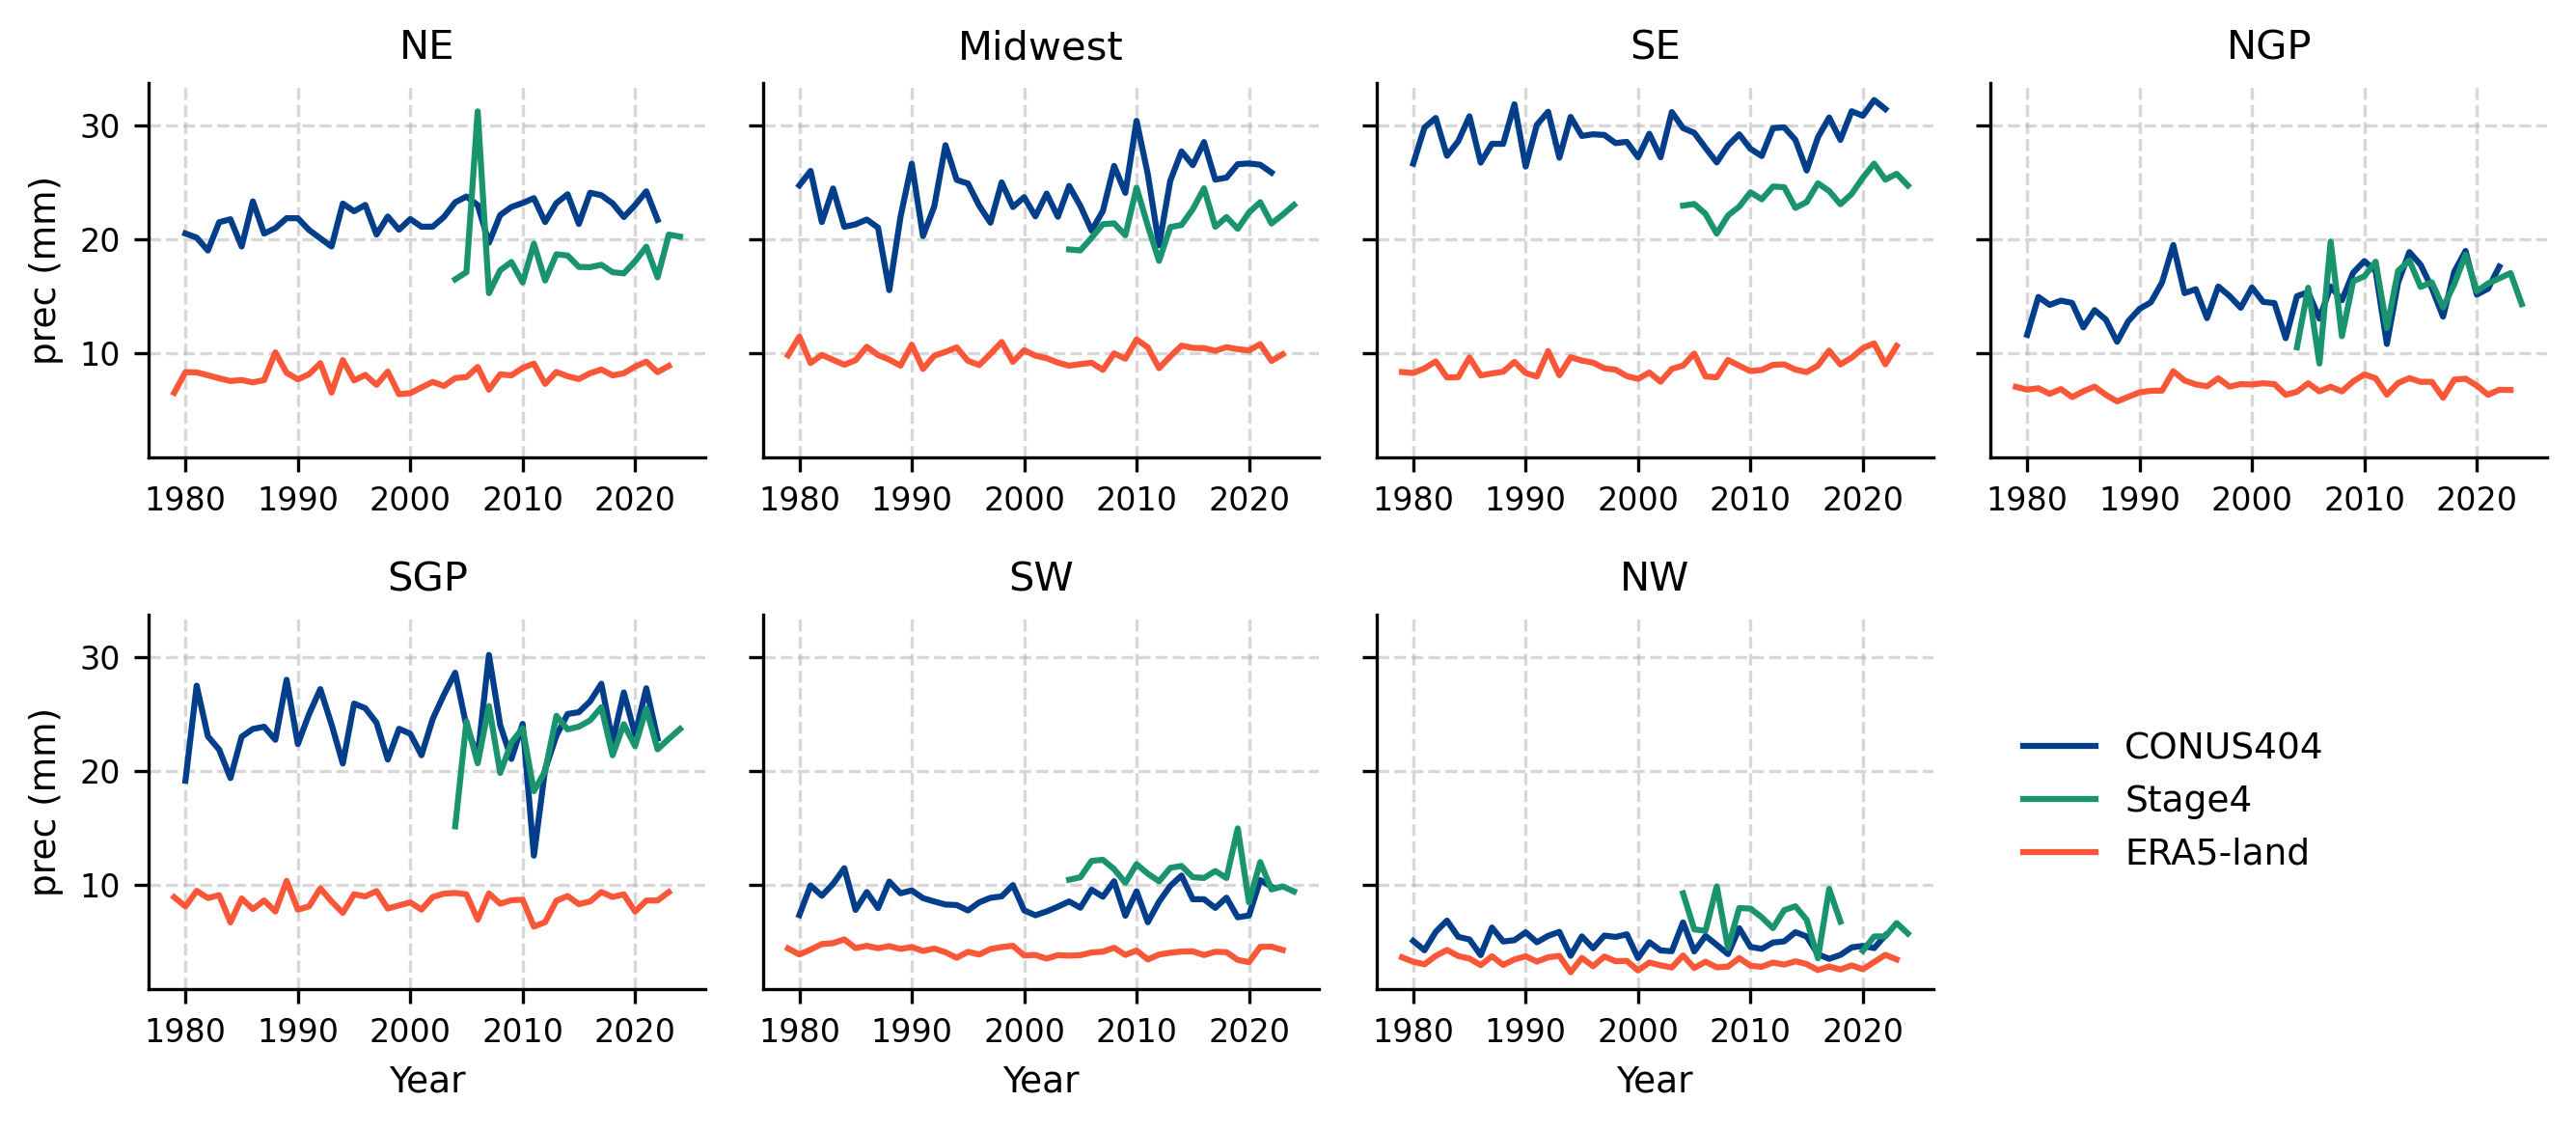

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['time'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

In [12]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_RxHhr_3_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_RxHhr_3_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_RxHhr_3_U*')


ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

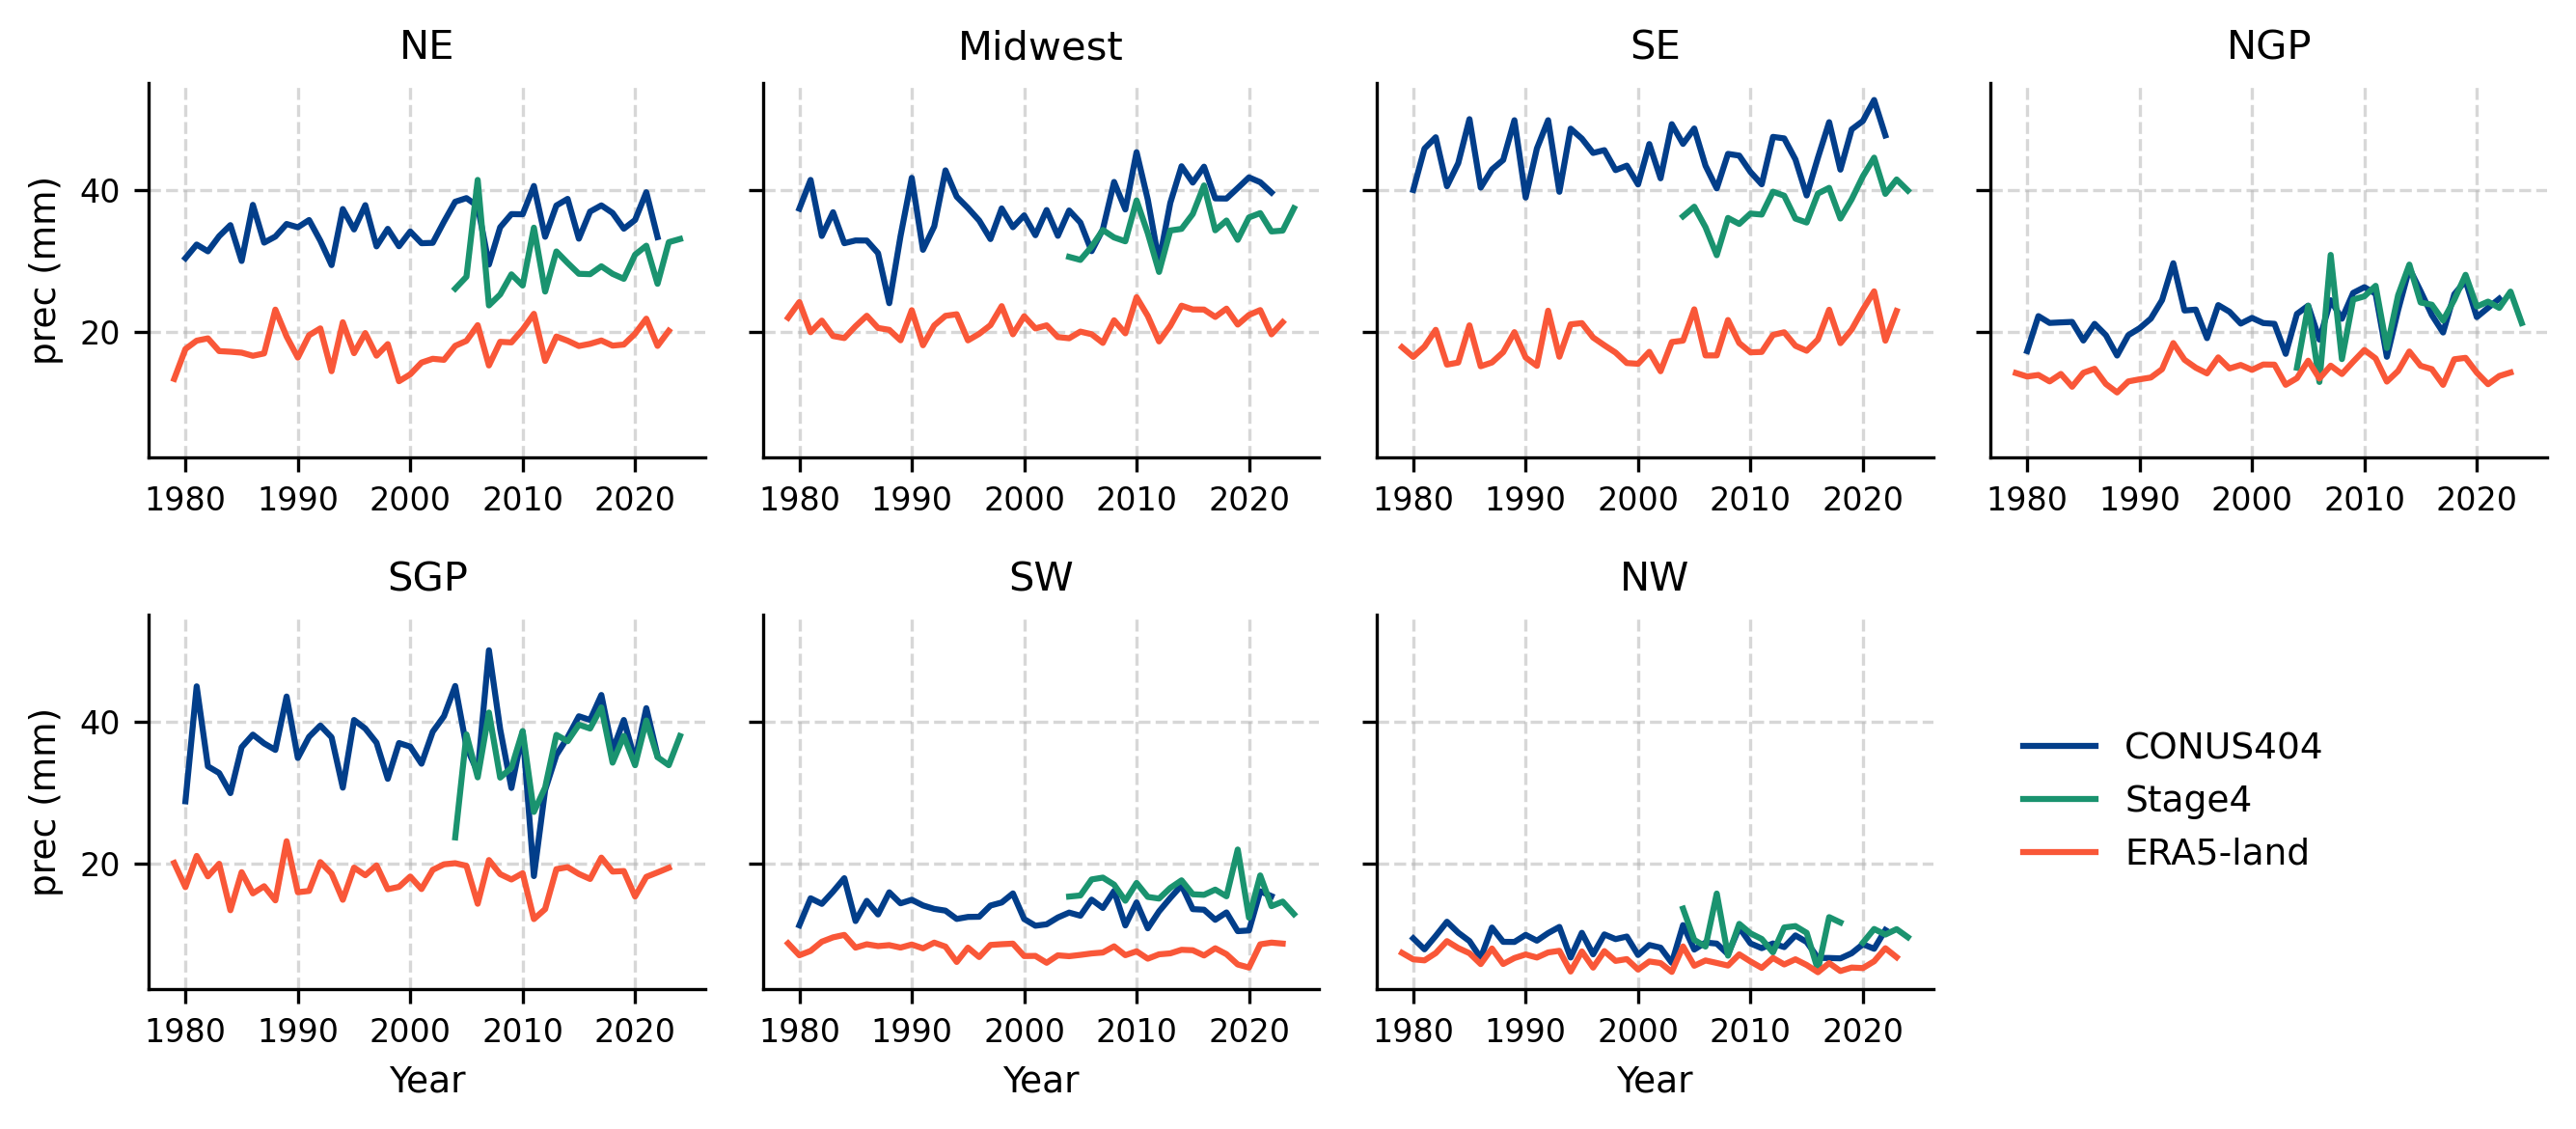

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['time'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

In [14]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_RxHhr_6_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_RxHhr_6_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_RxHhr_6_U*')


ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

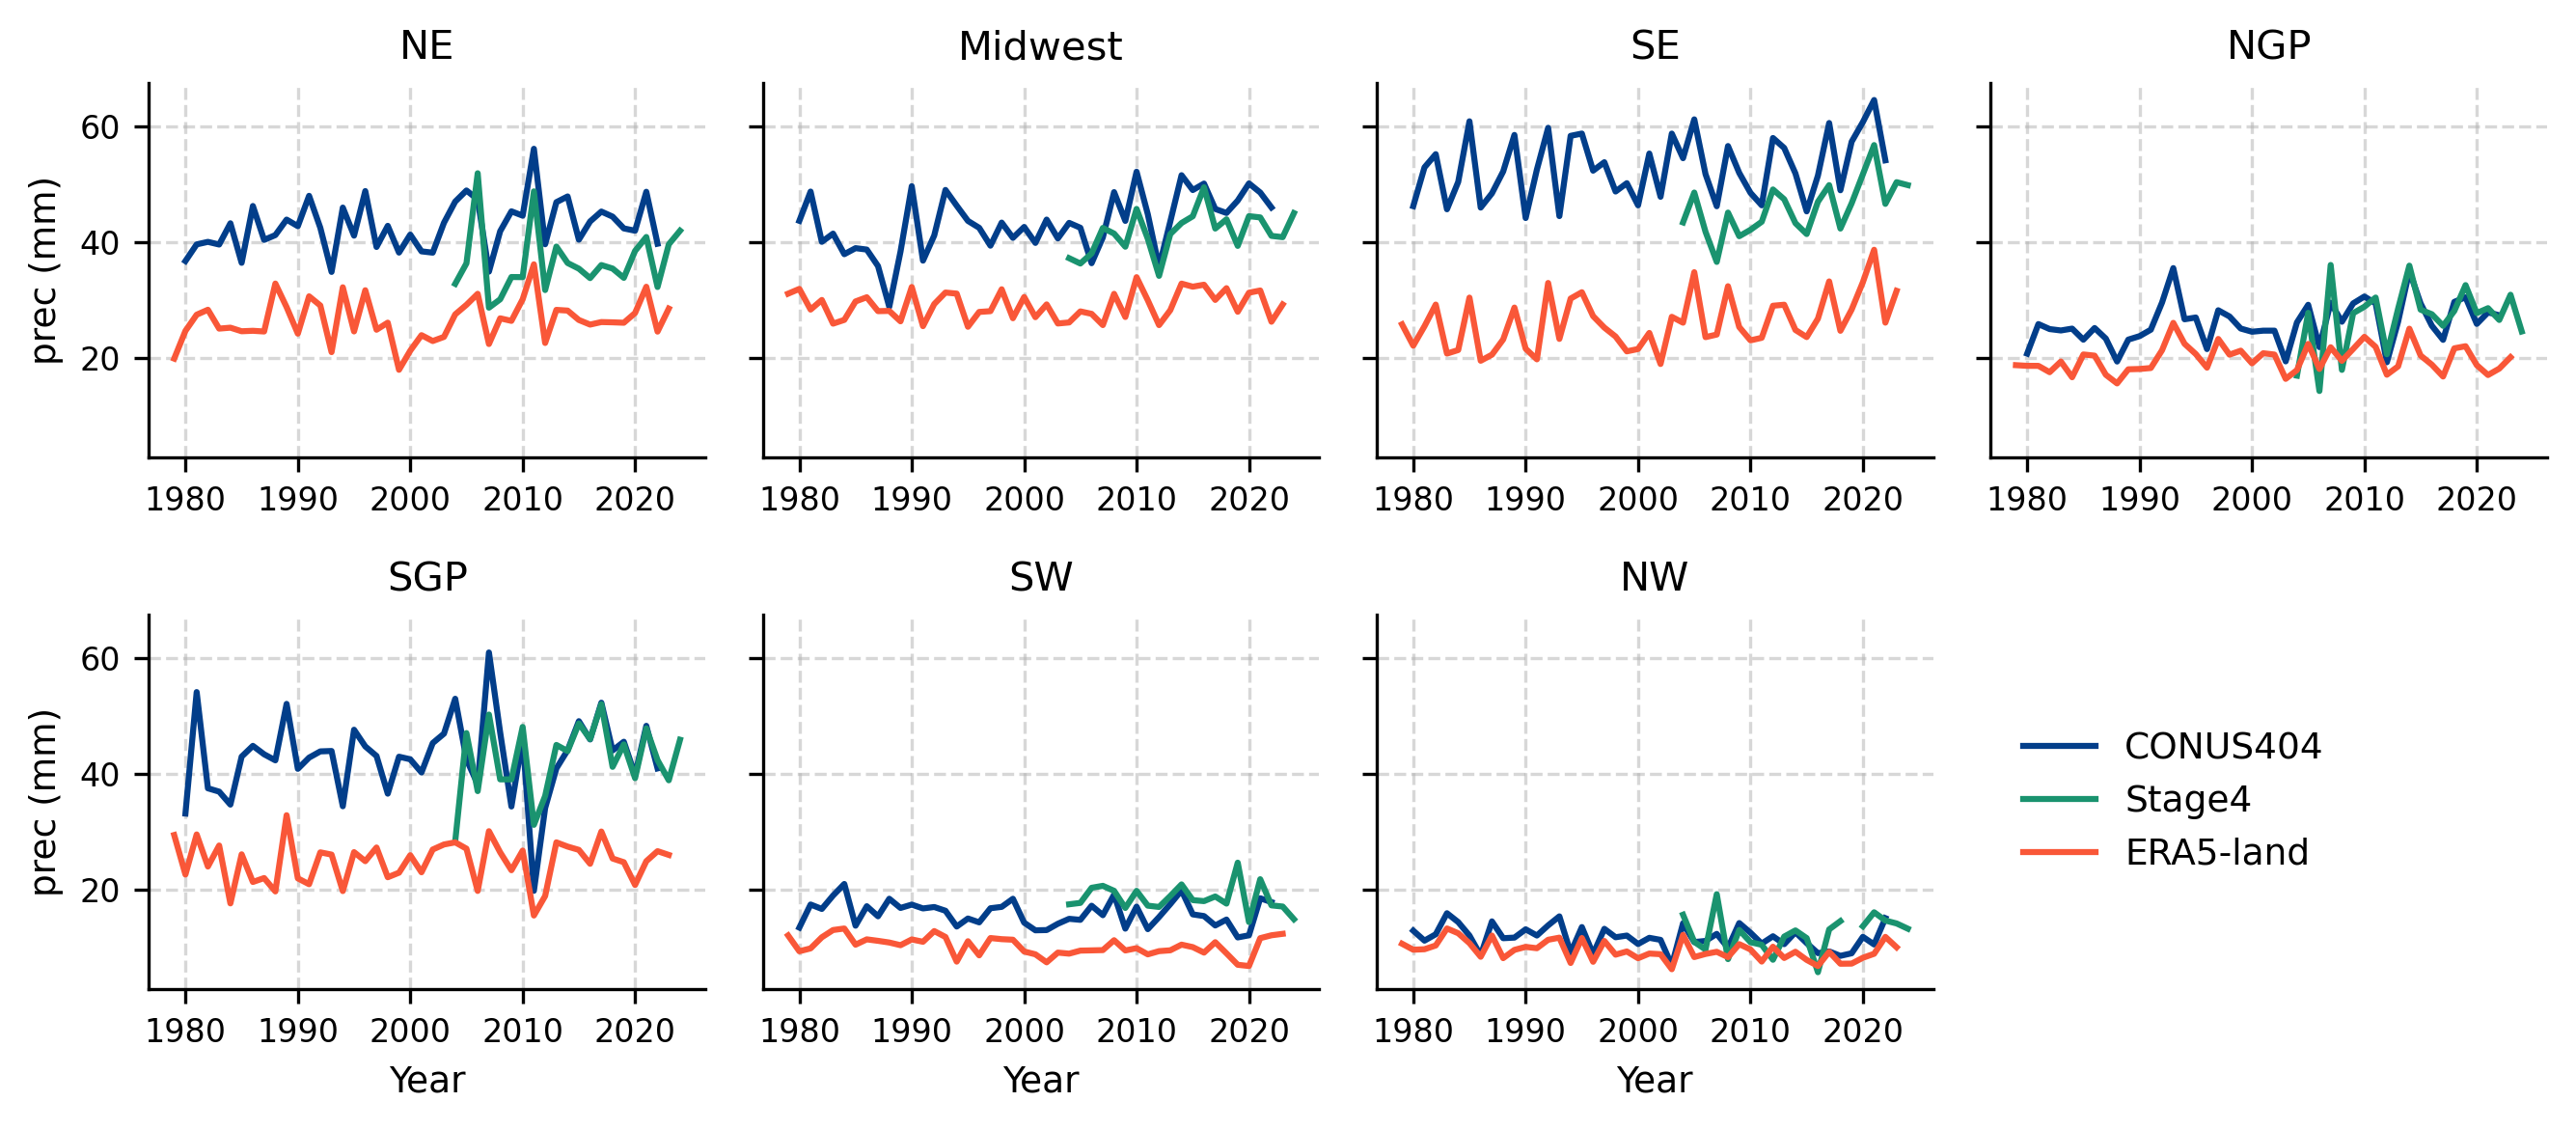

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['time'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

In [16]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_RxHhr_12_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_RxHhr_12_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_RxHhr_12_U*')


ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

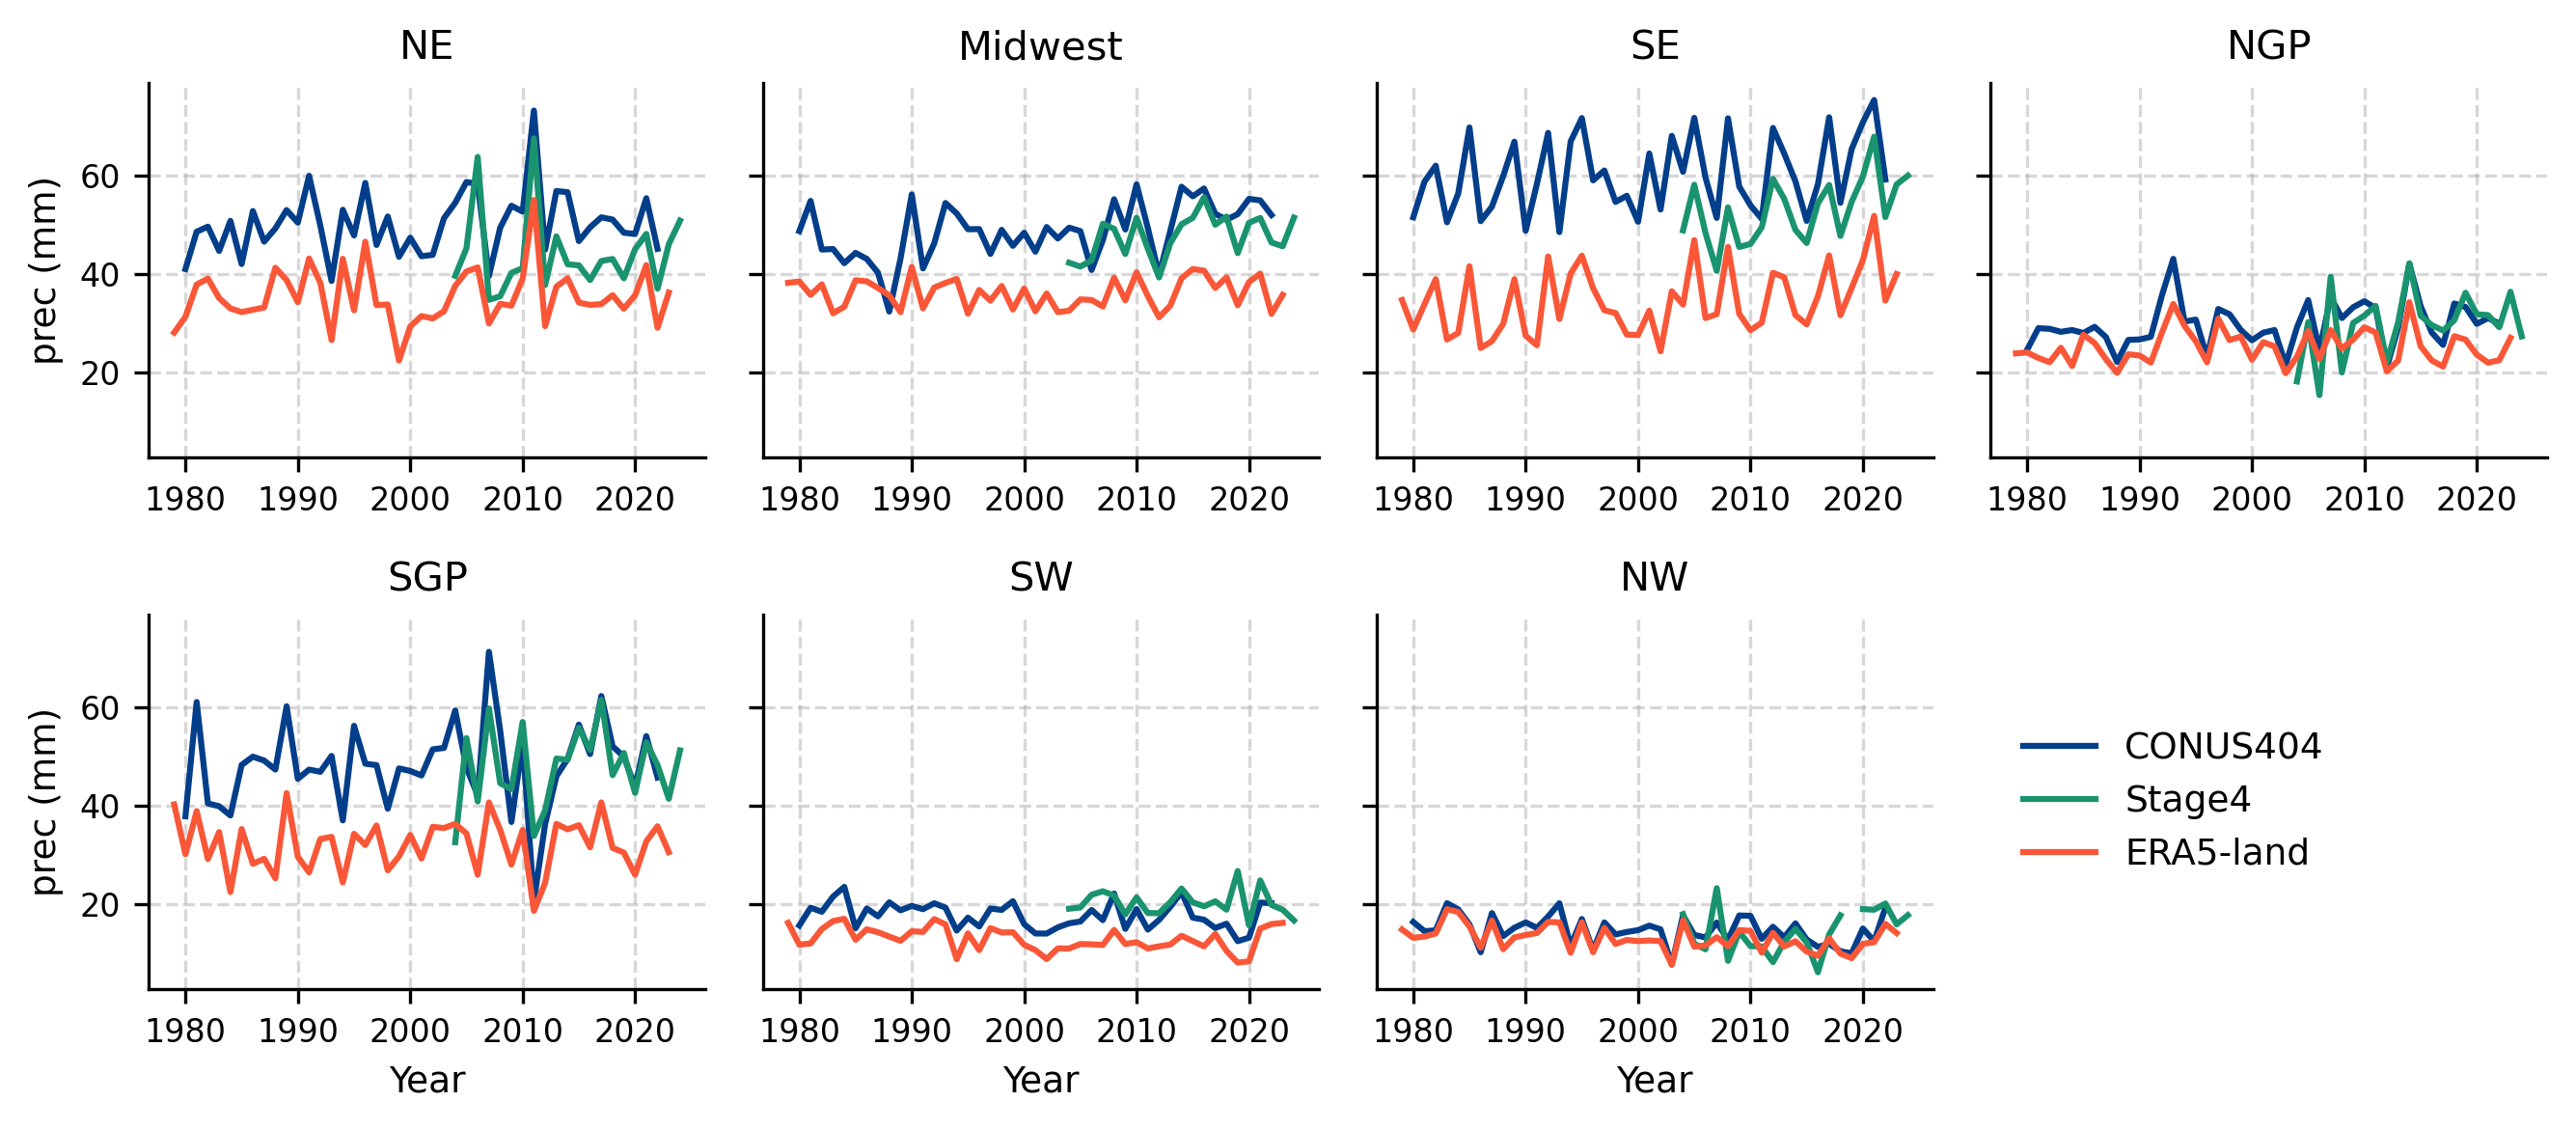

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['time'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

In [18]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_RxHhr_24_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_RxHhr_24_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_RxHhr_24_U*')


ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

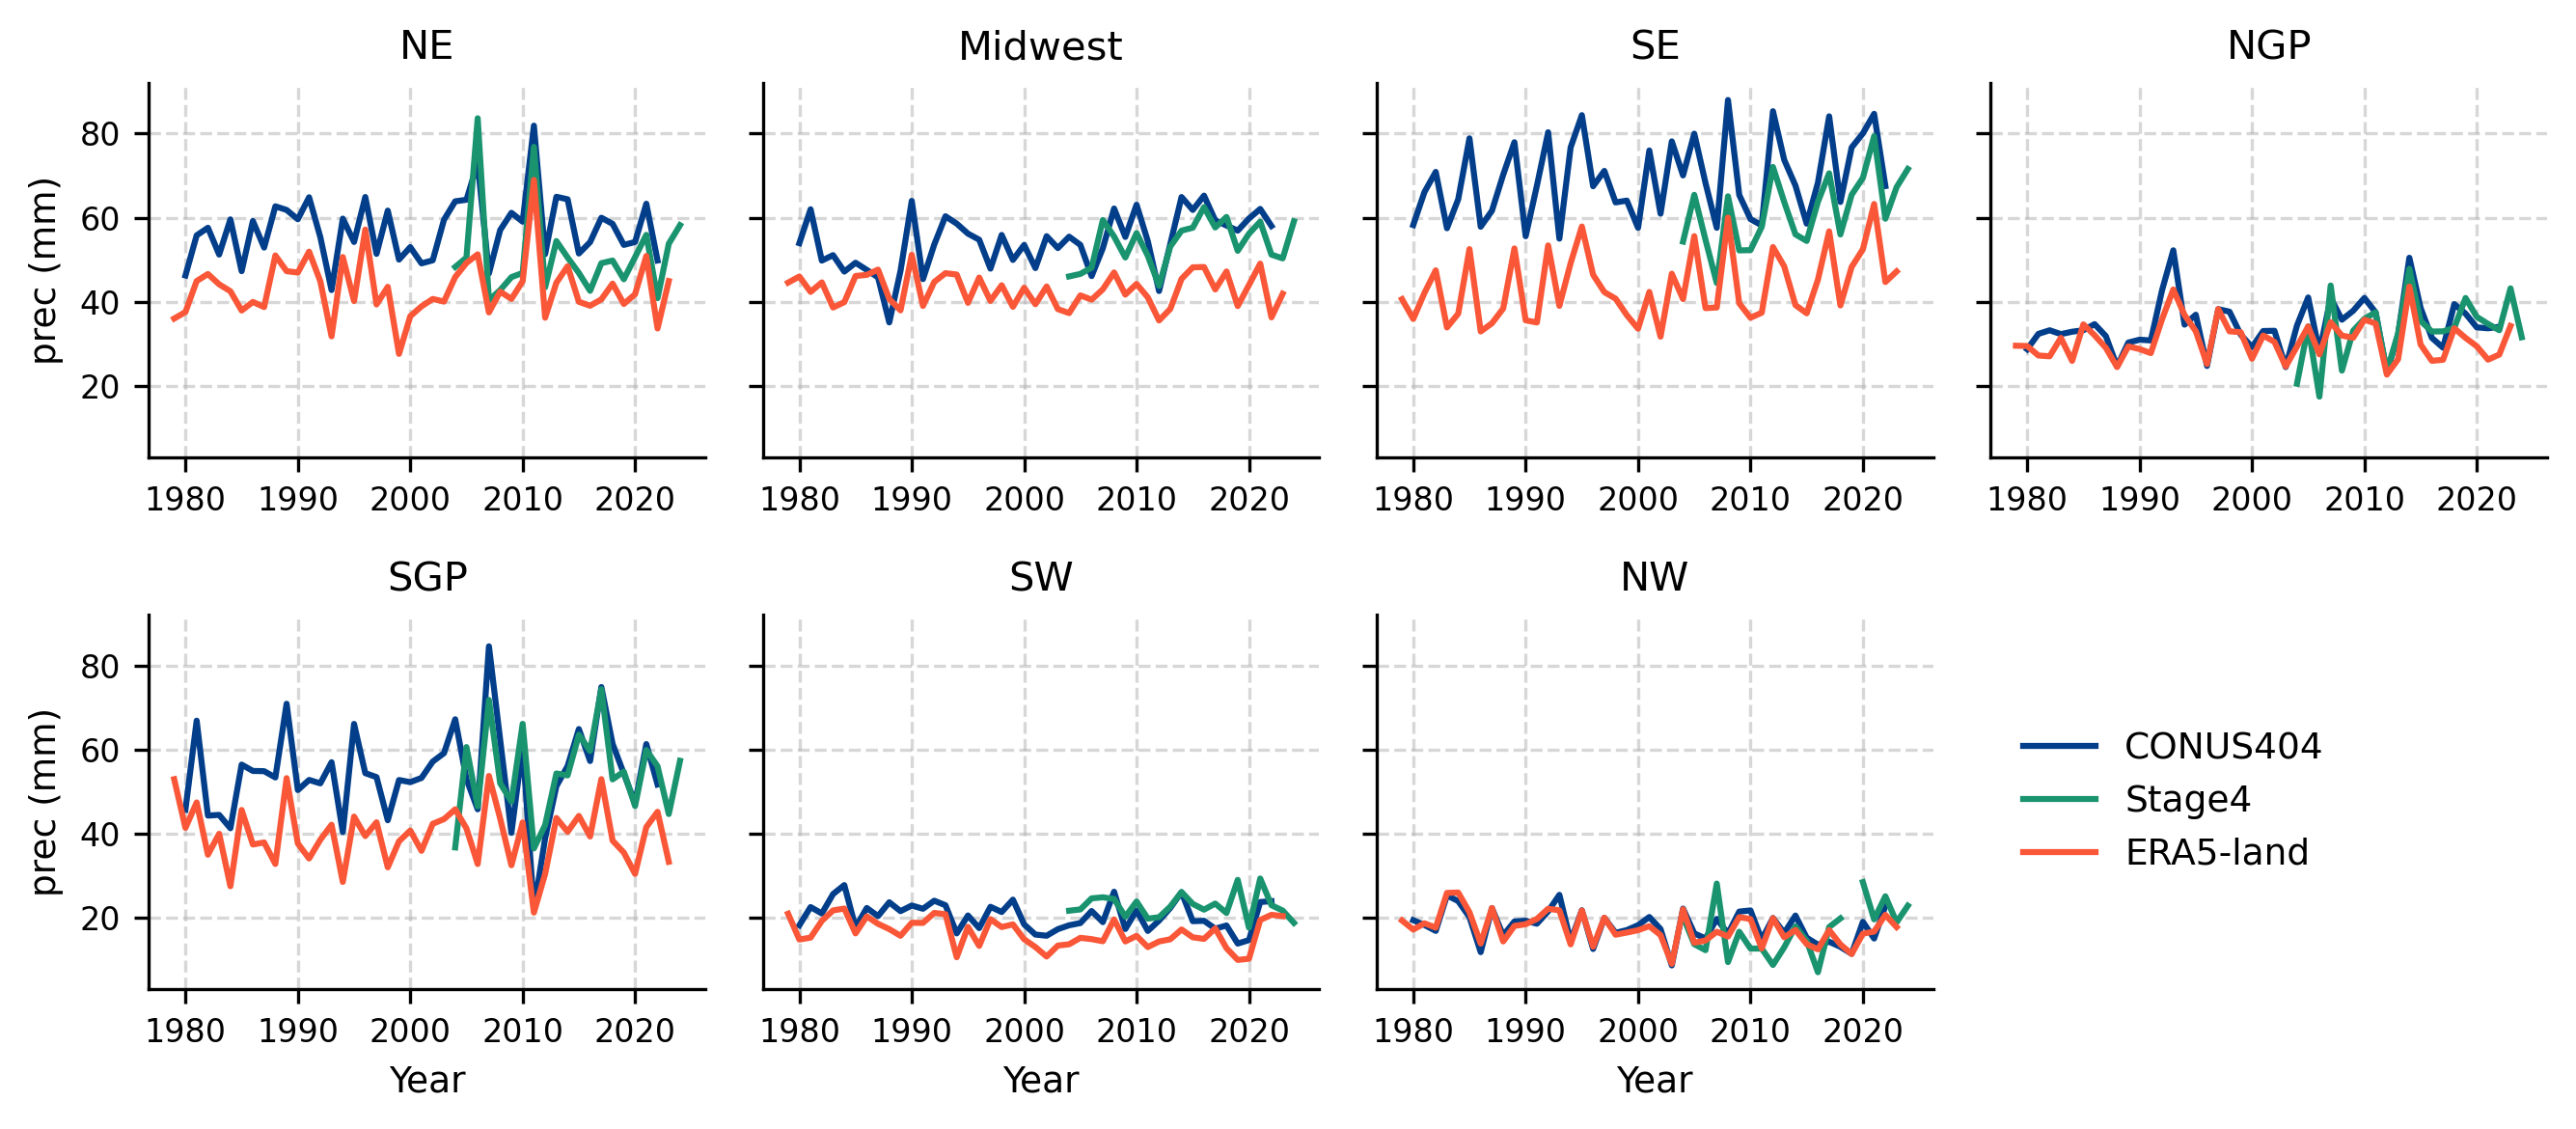

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['time'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

## Percentage contribution of Rx1hr (1-hour maximum) to the total precipitation of the corresponding calendar day (00:00-00:00 local time)

In [20]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_Rx1hrP_U*').mean('day')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_Rx1hrP_U*').mean('day')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_Rx1hrP_U*').mean('day')

ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

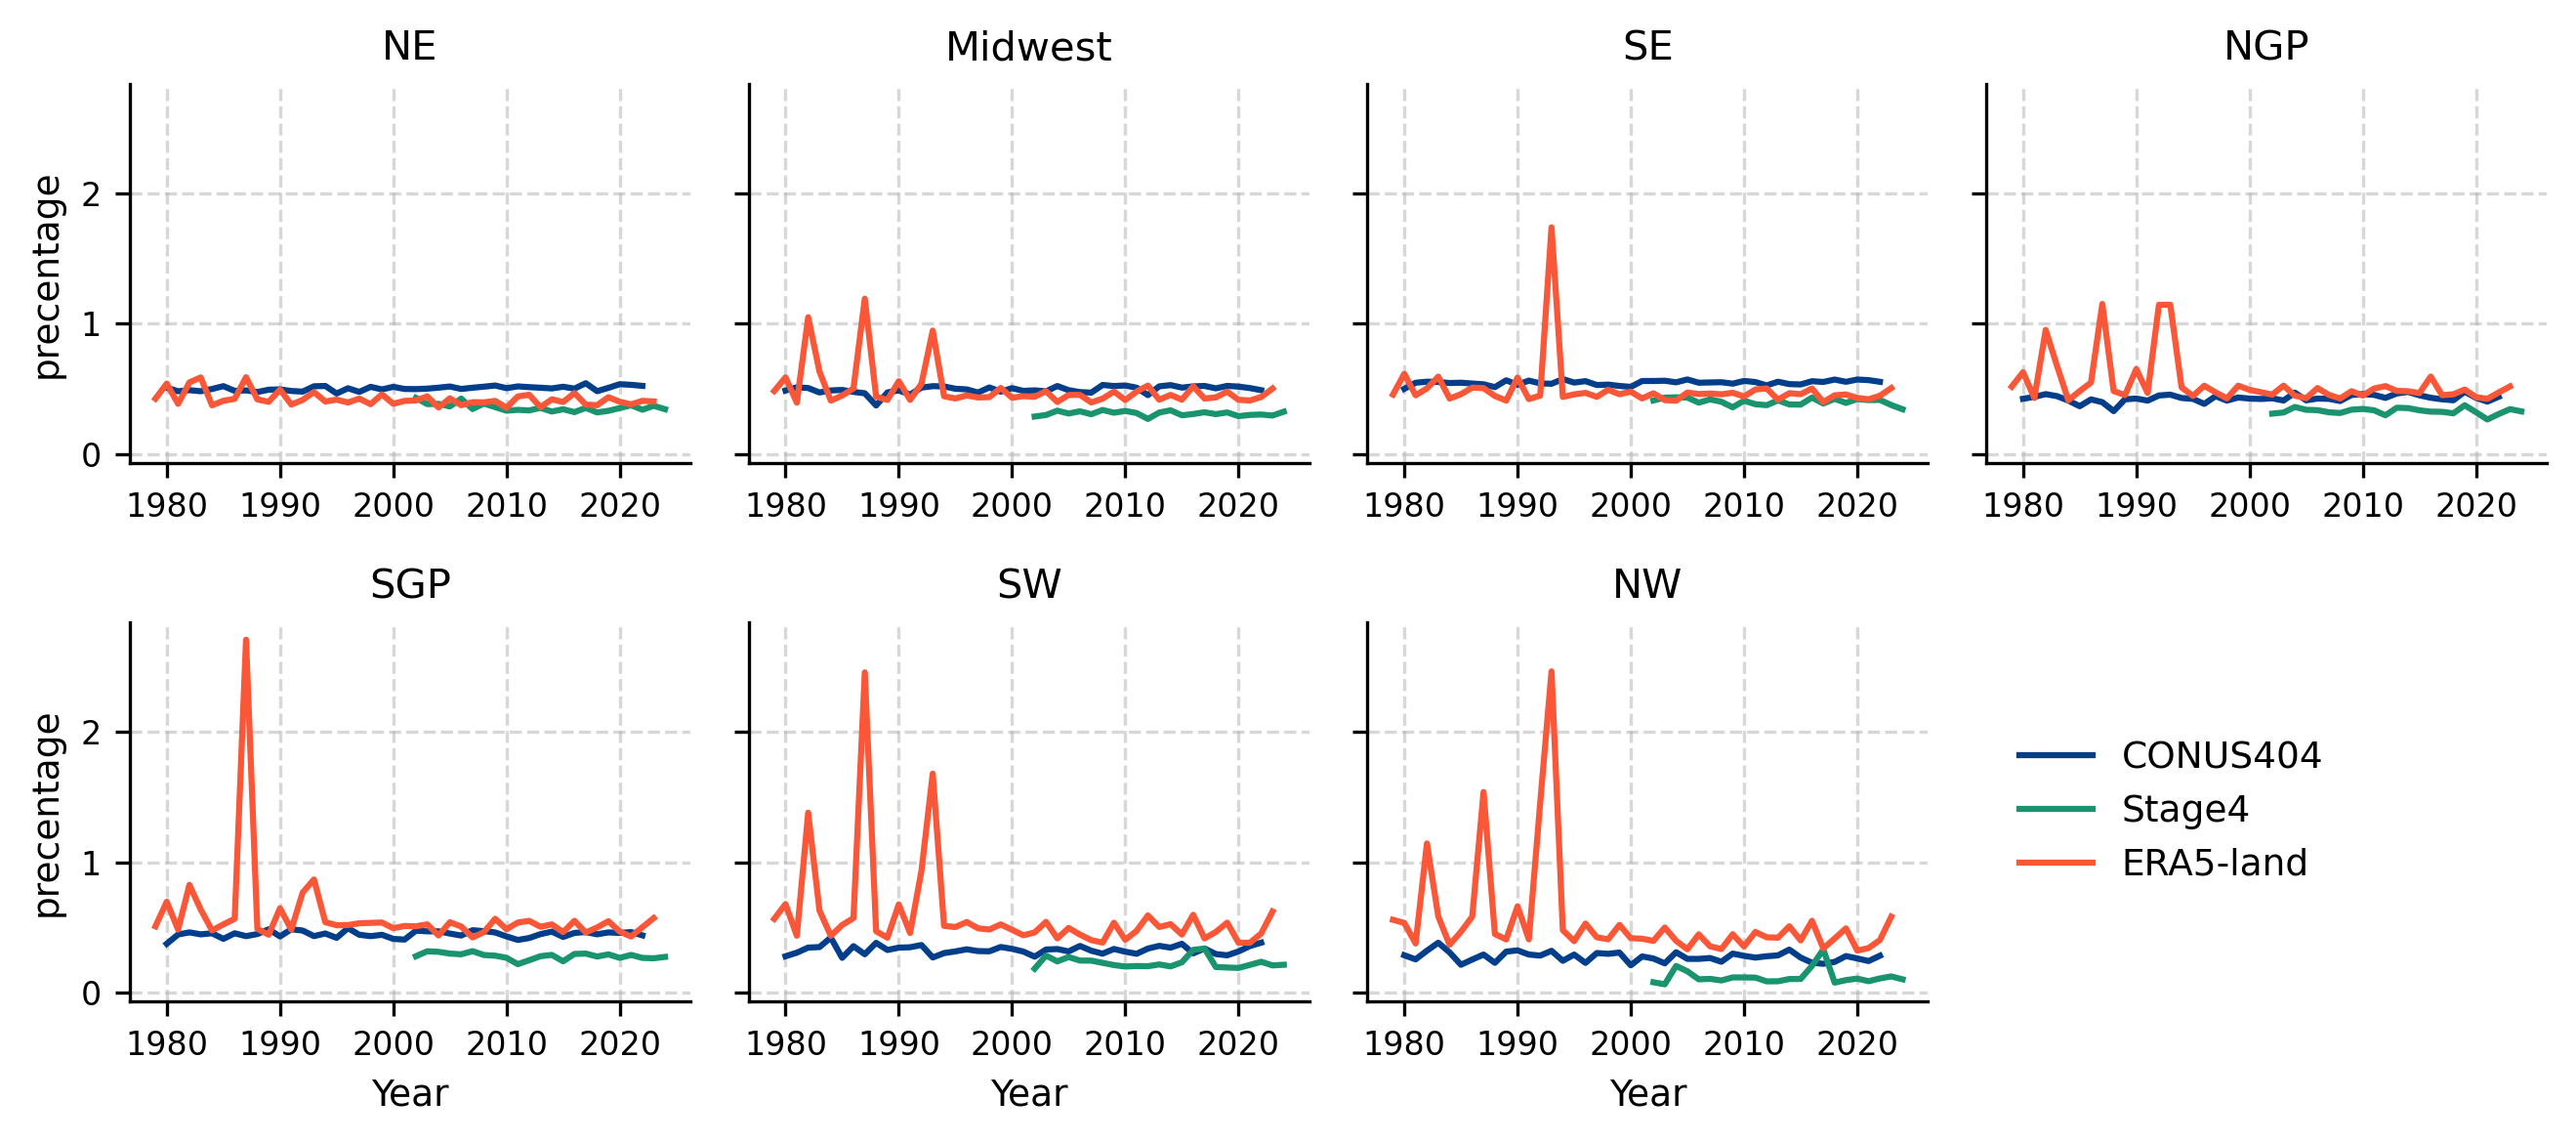

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['percent'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('precentage', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

## Count of hours (or multi-hour intervals if H is greater than 1) greater than 10, 20, 30 or 50 mm thresholds (T)

In [22]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_RHhrTmm_1_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_RHhrTmm_1_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_RHhrTmm_1_U*')

ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

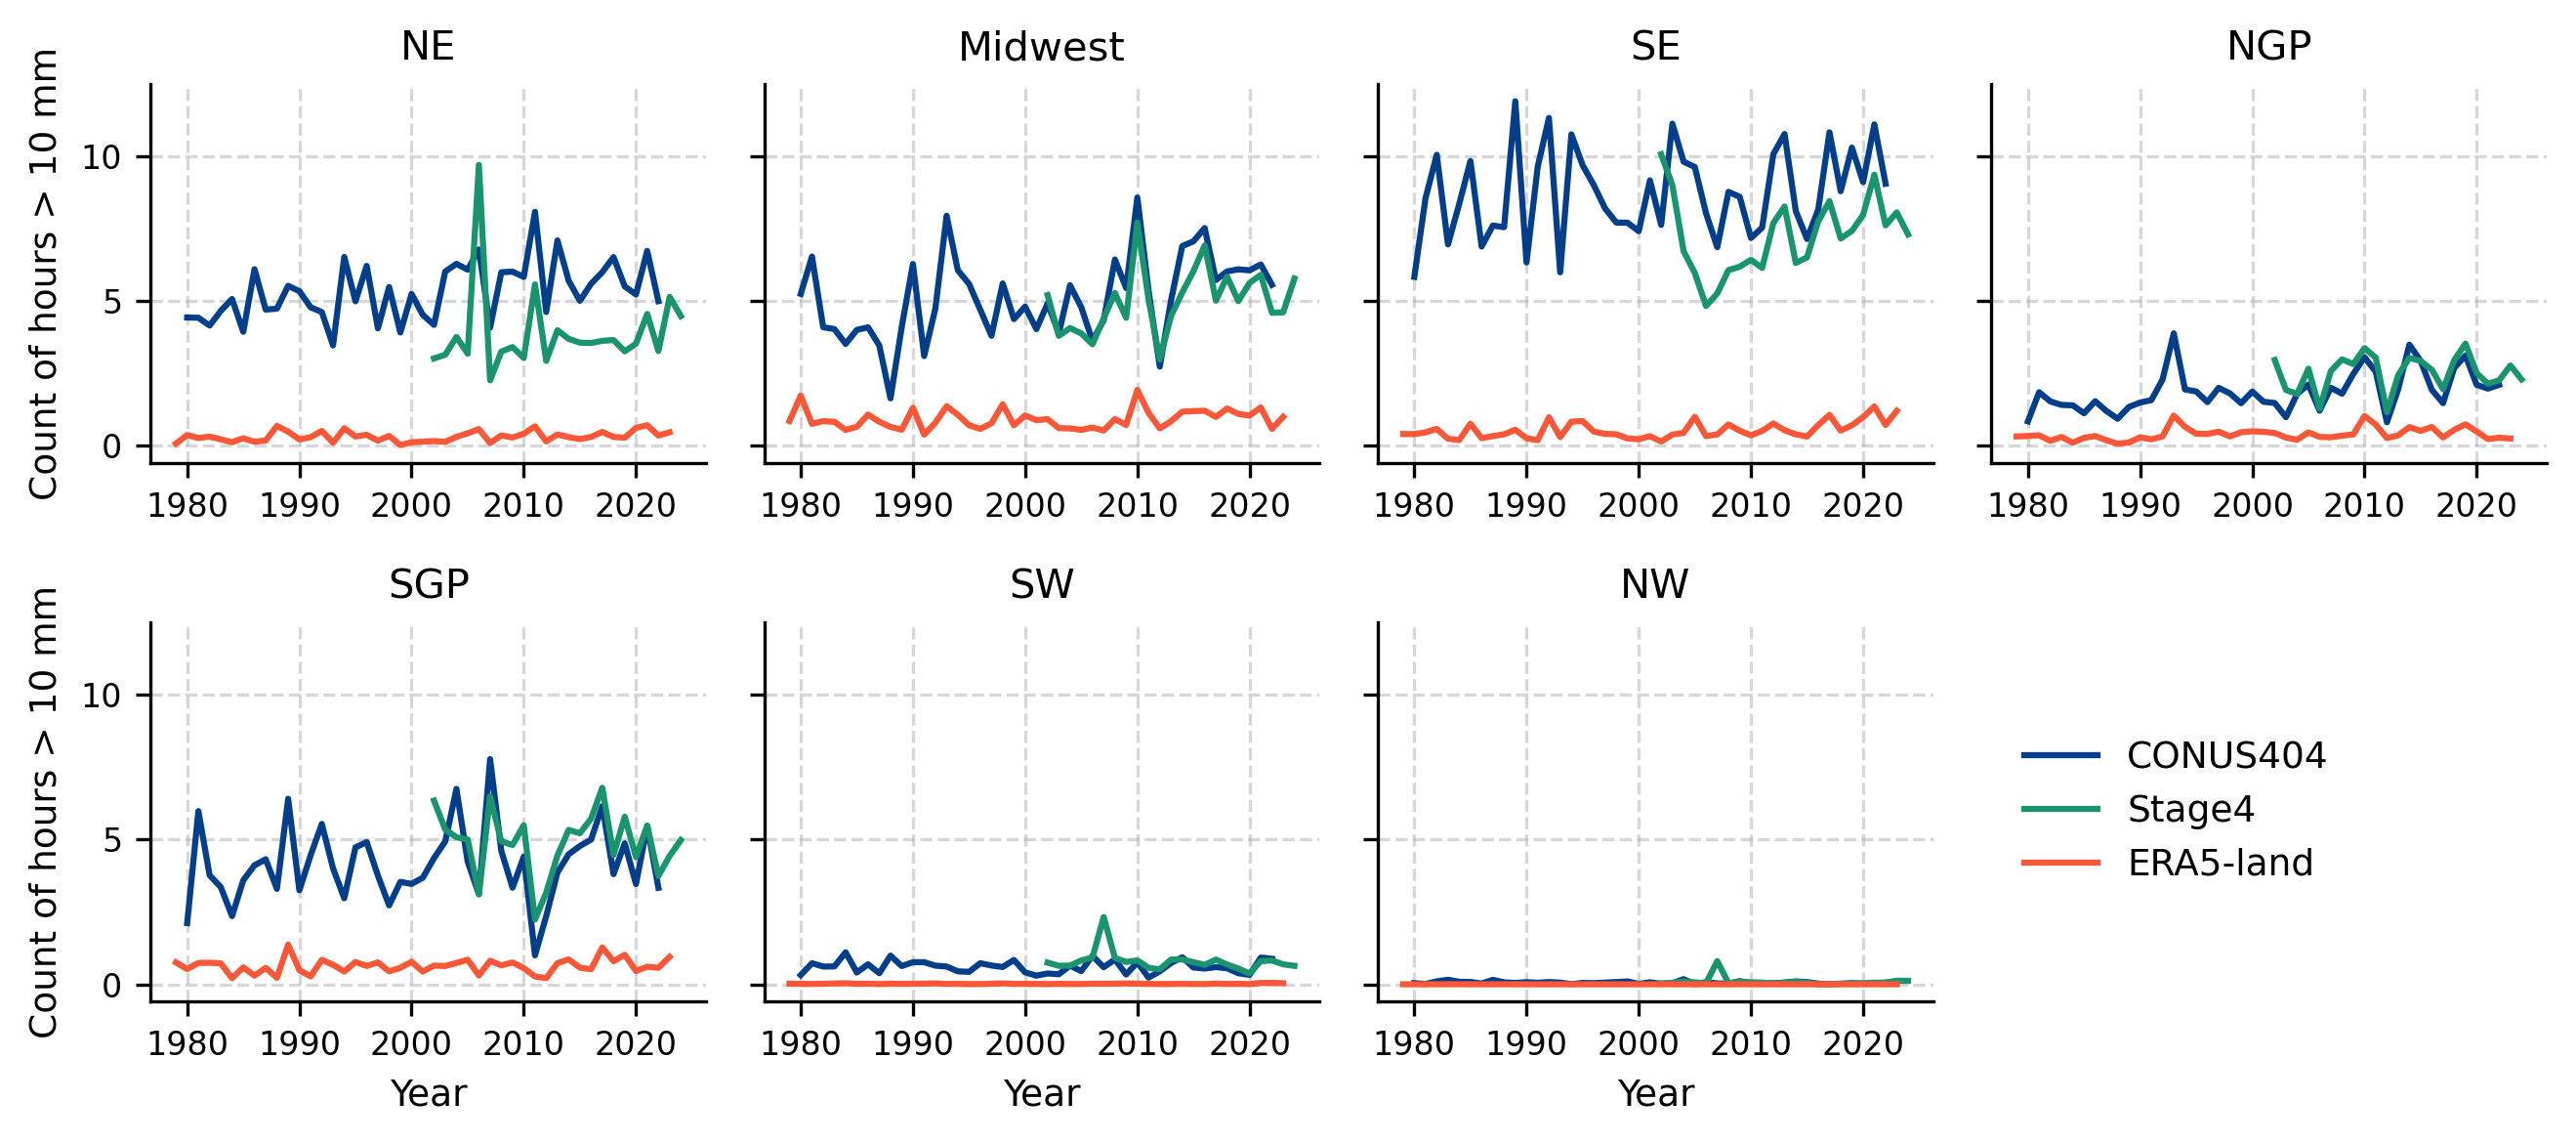

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['c_10'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('Count of hours > 10 mm', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

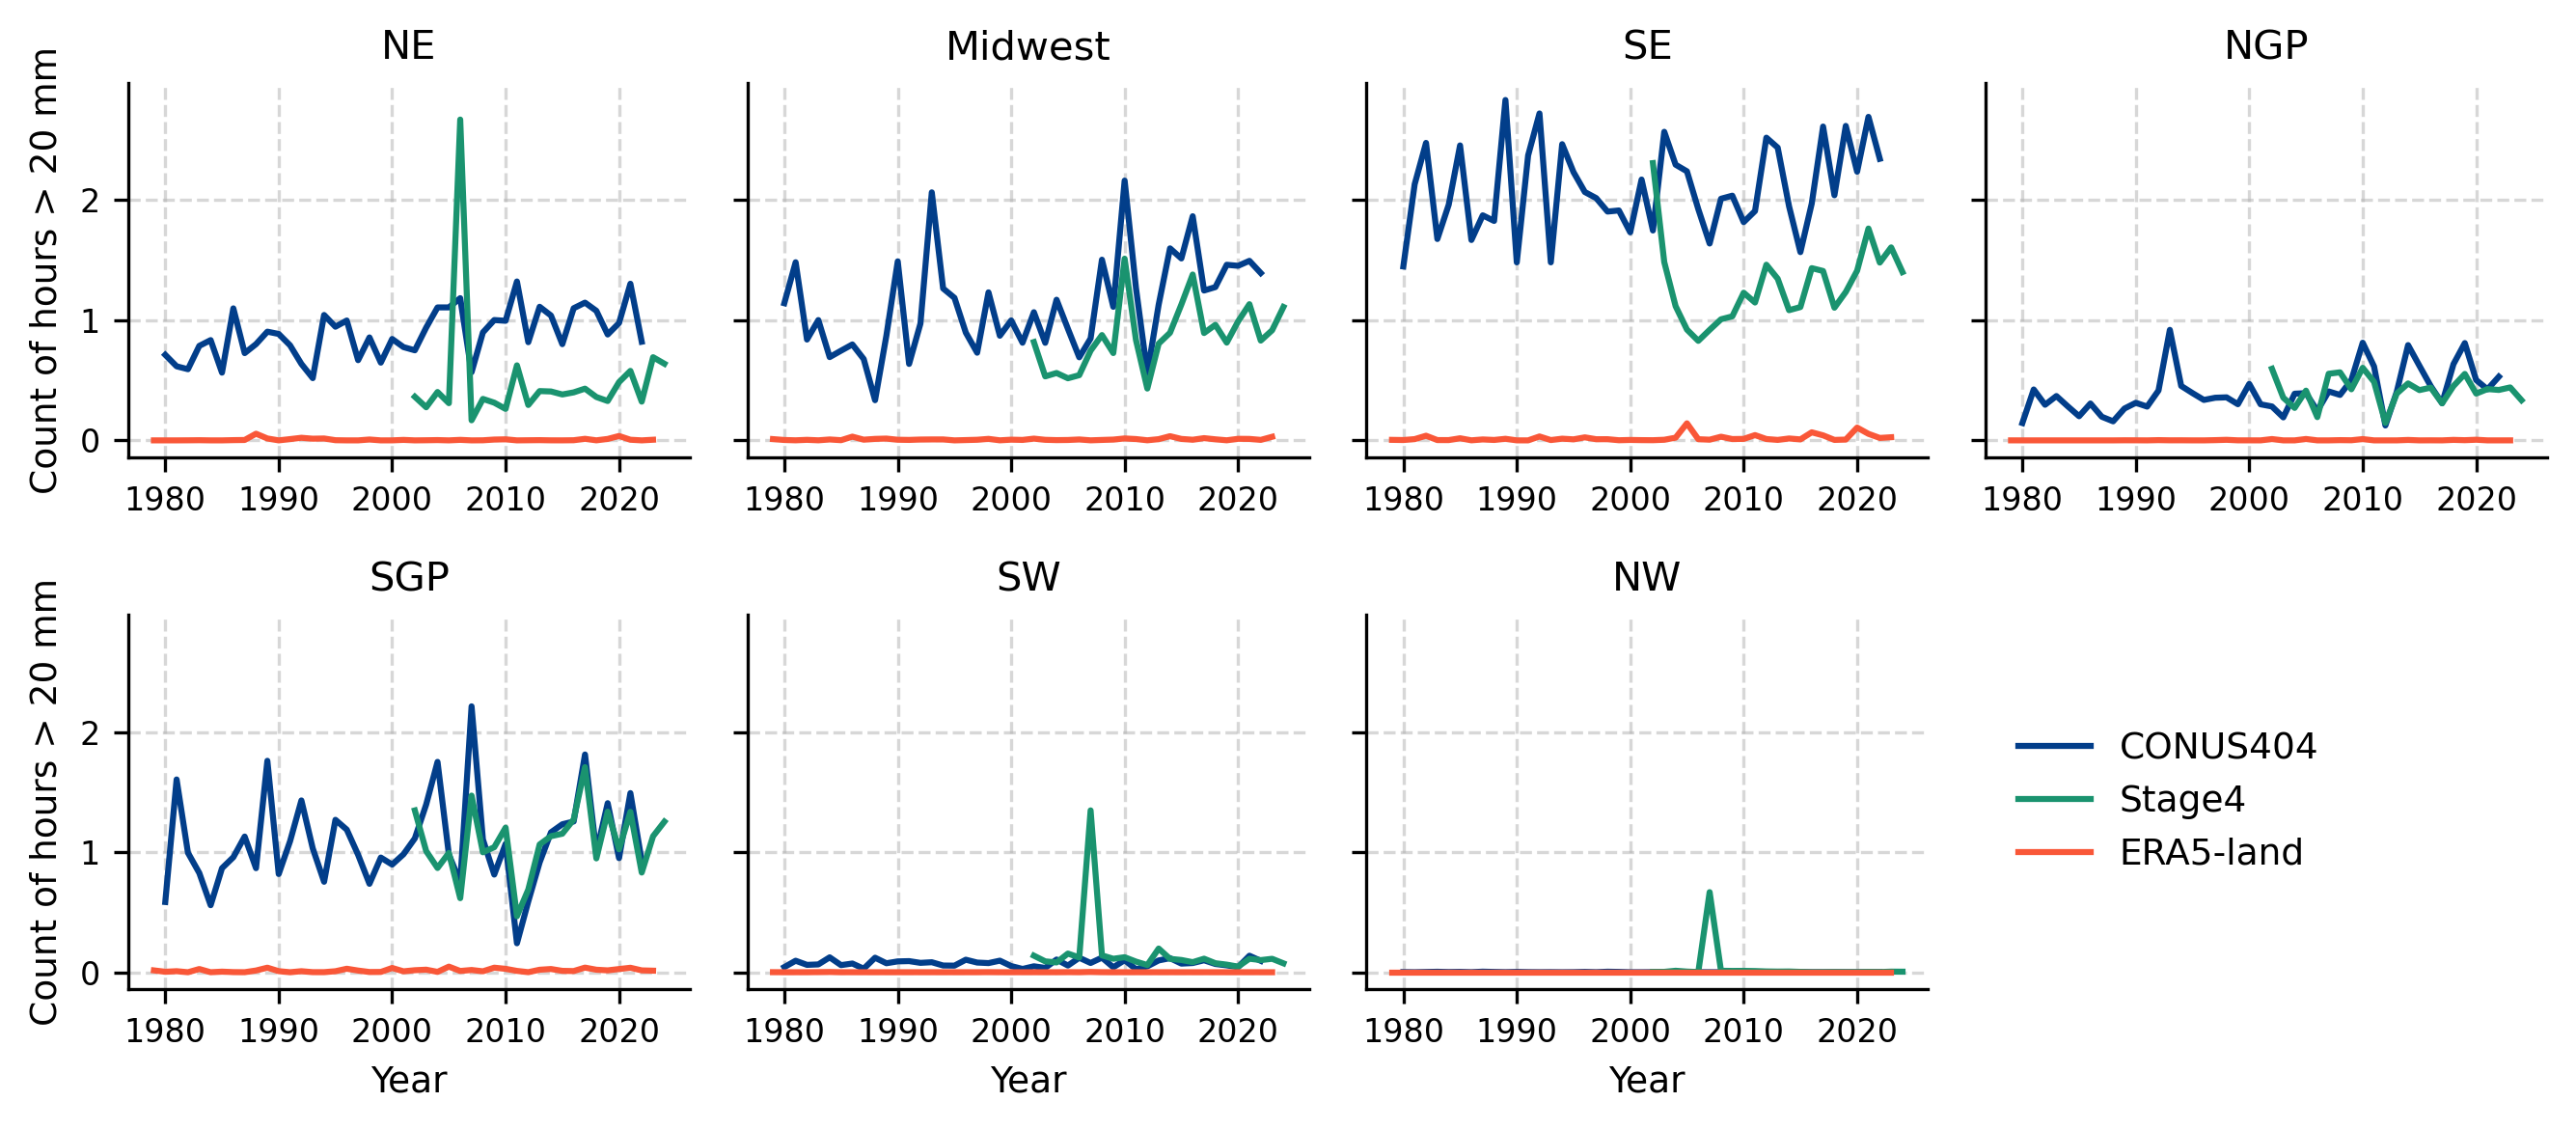

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['c_20'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('Count of hours > 20 mm', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

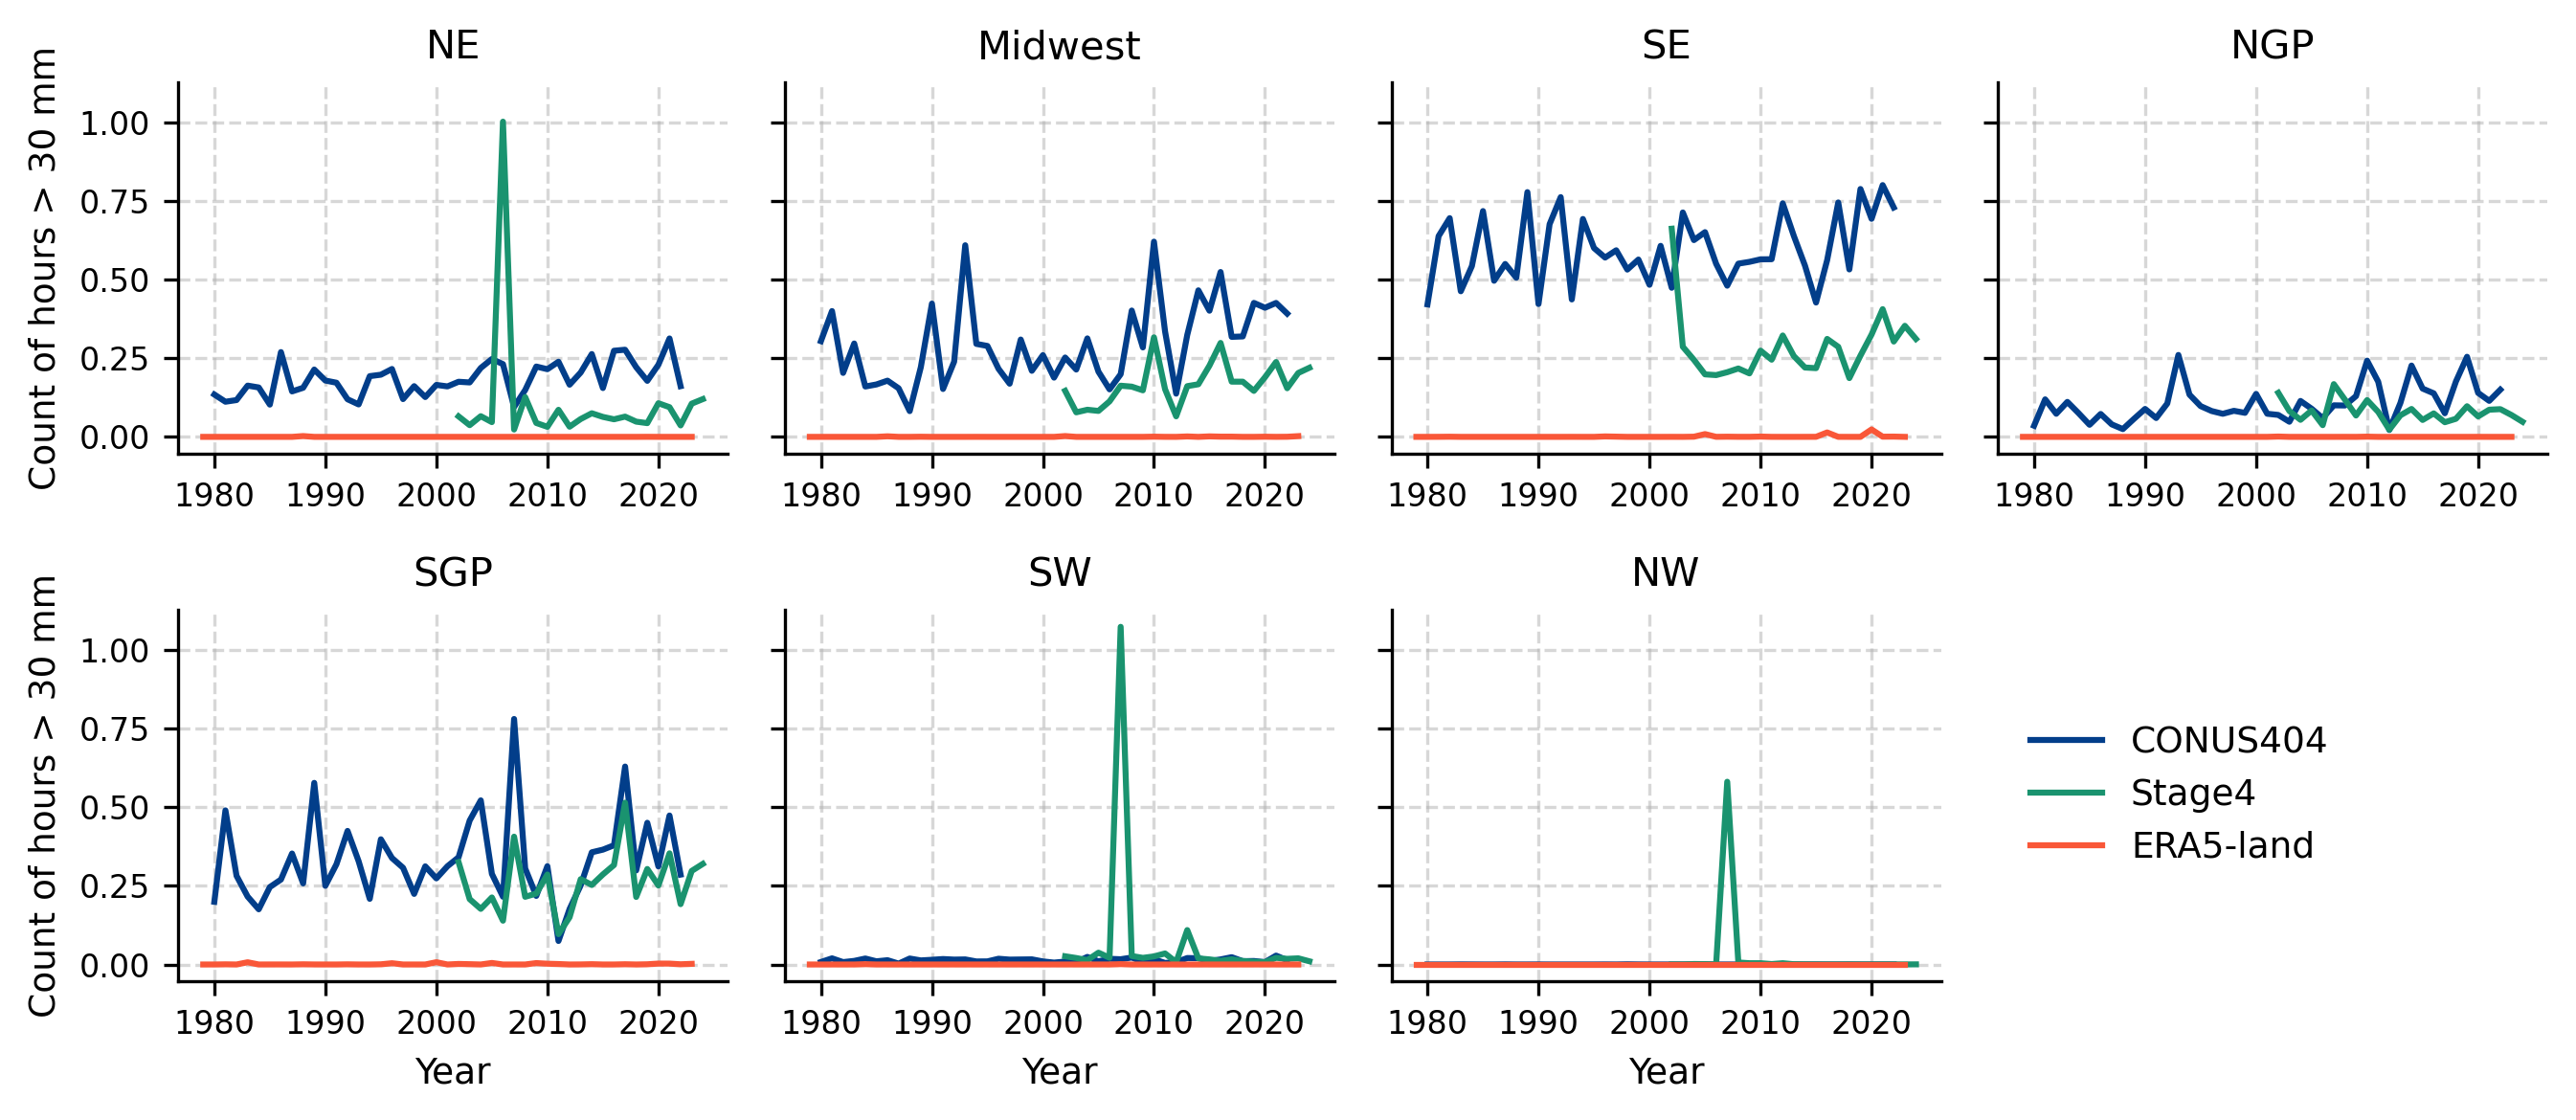

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['c_30'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('Count of hours > 30 mm', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

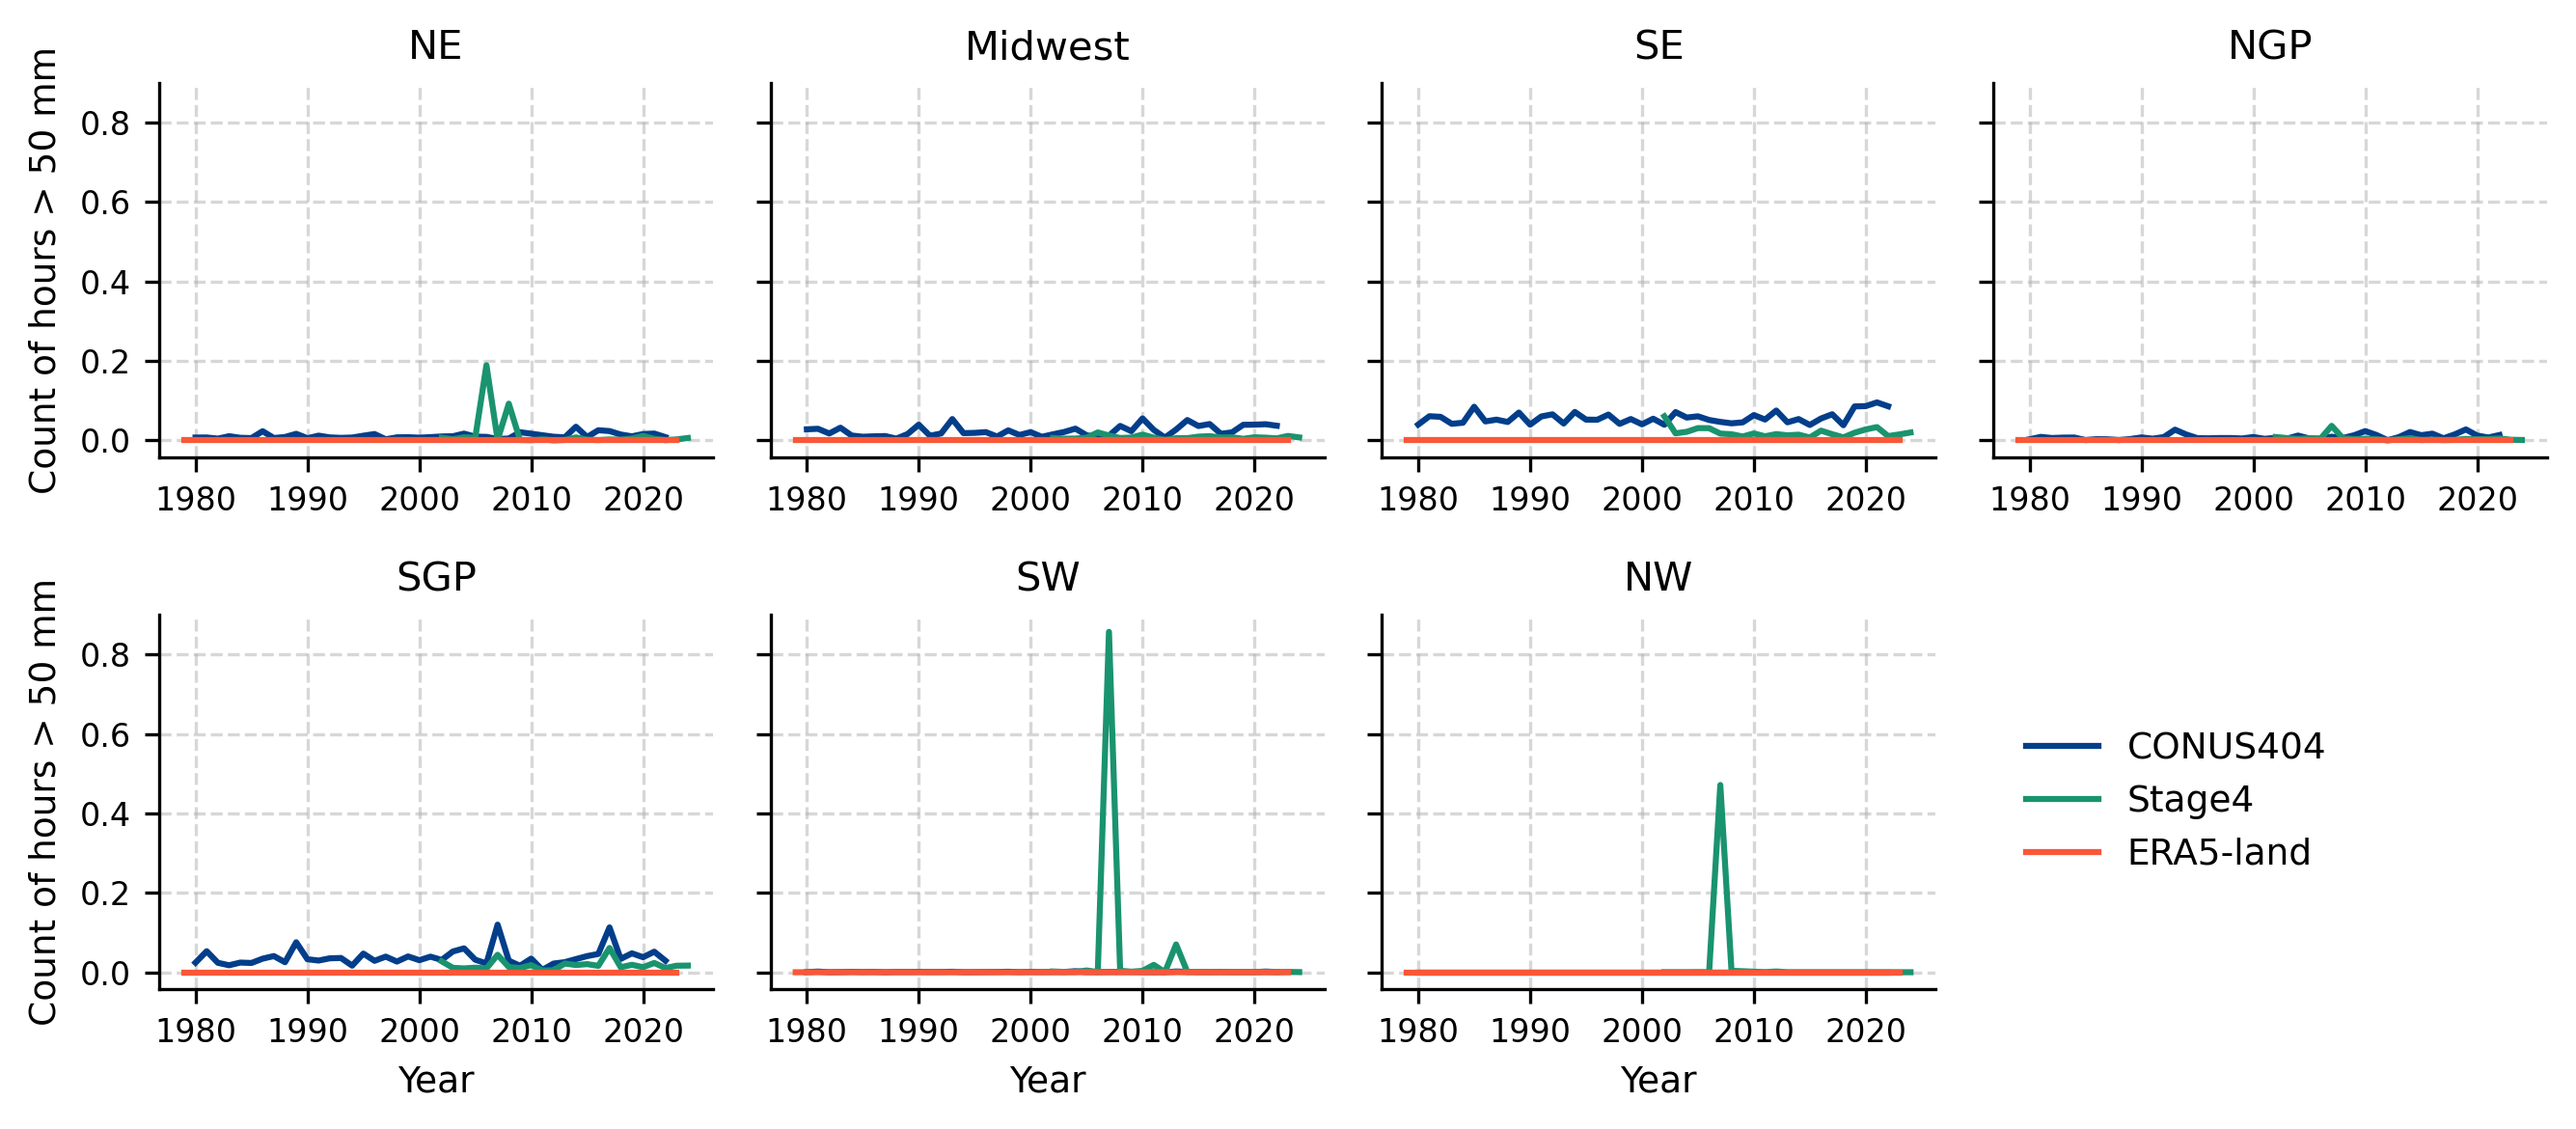

In [26]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['c_50'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('Count of hours > 50 mm', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

## Total number of wet hours

In [27]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_NWH_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_NWH_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_NWH_U*')

ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

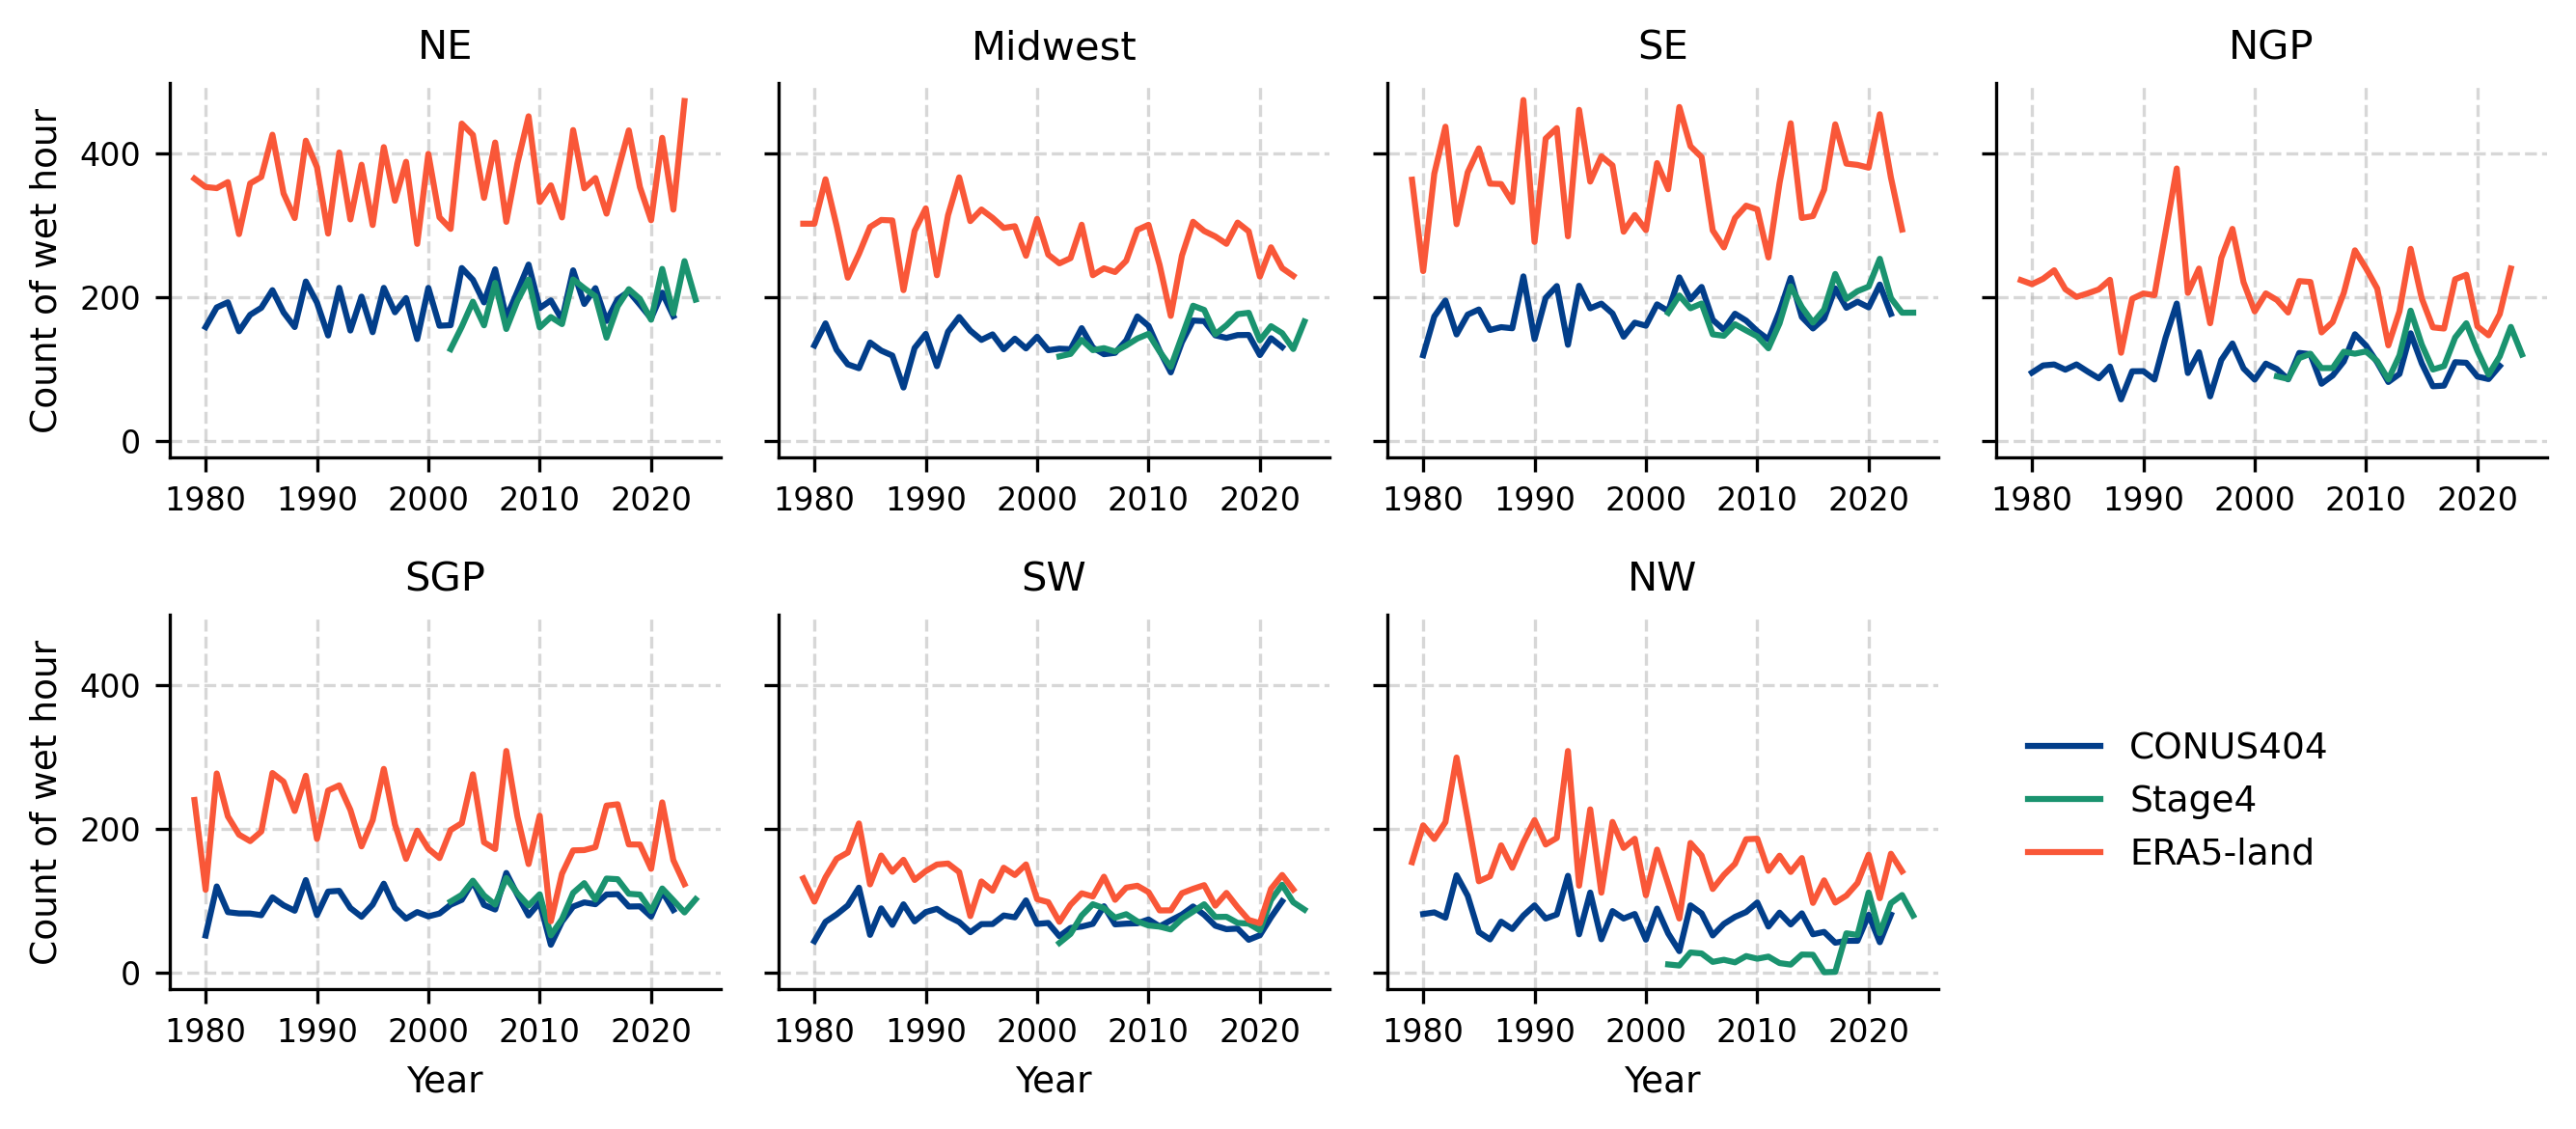

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['c'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('Count of wet hour', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

In [29]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_SPIIHhr_1_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_SPIIHhr_1_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_SPIIHhr_1_U*')

ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

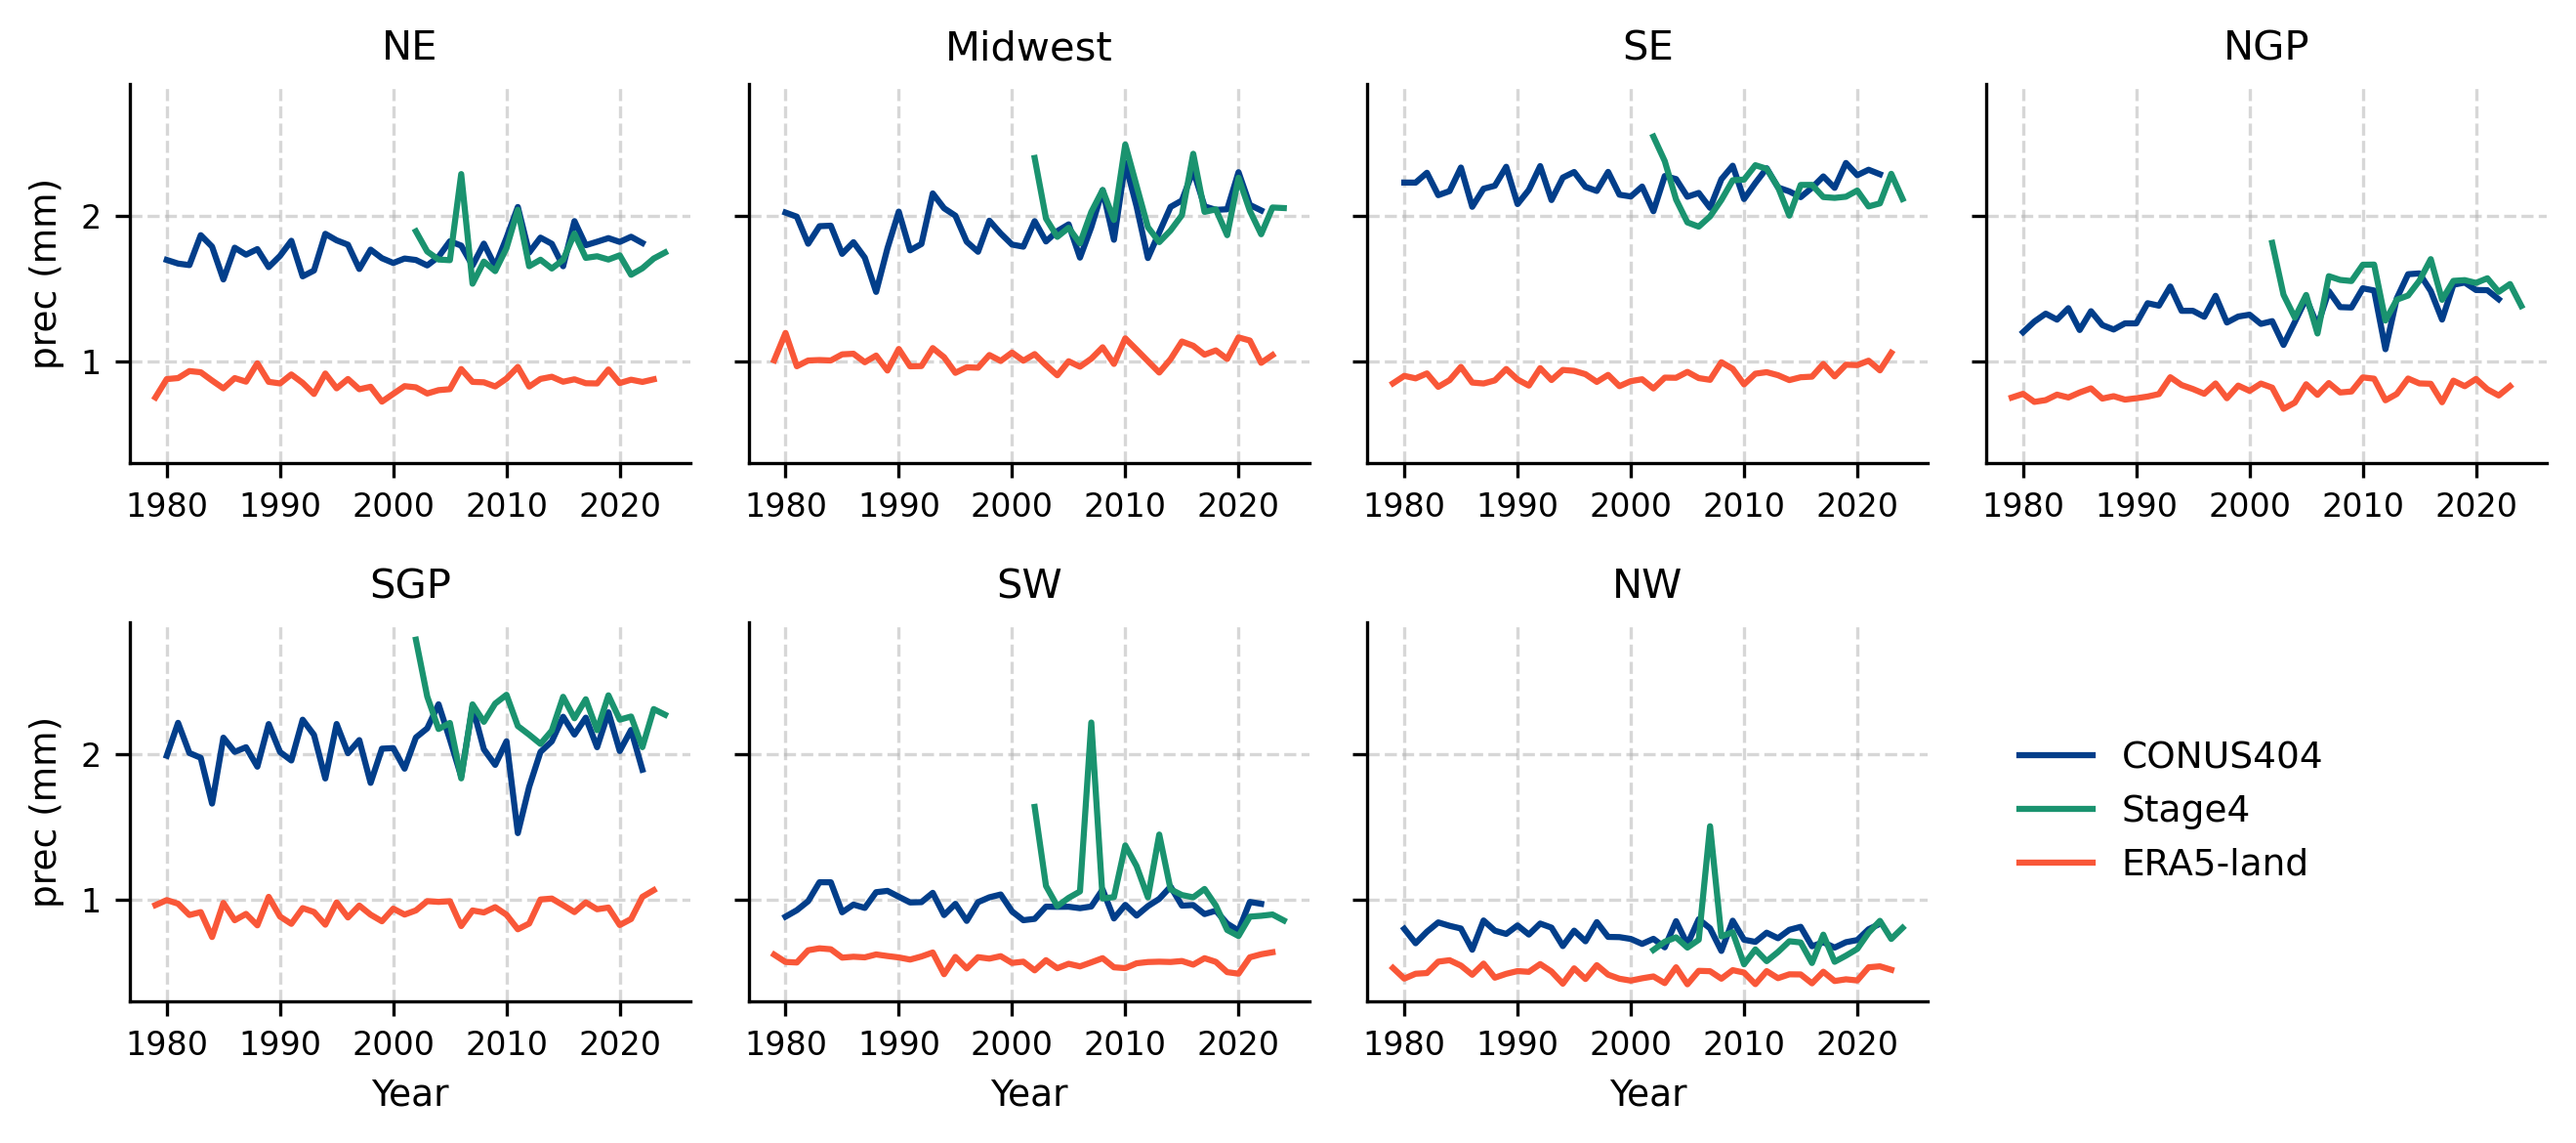

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

In [31]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_SPIIHhr_3_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_SPIIHhr_3_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_SPIIHhr_3_U*')

ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

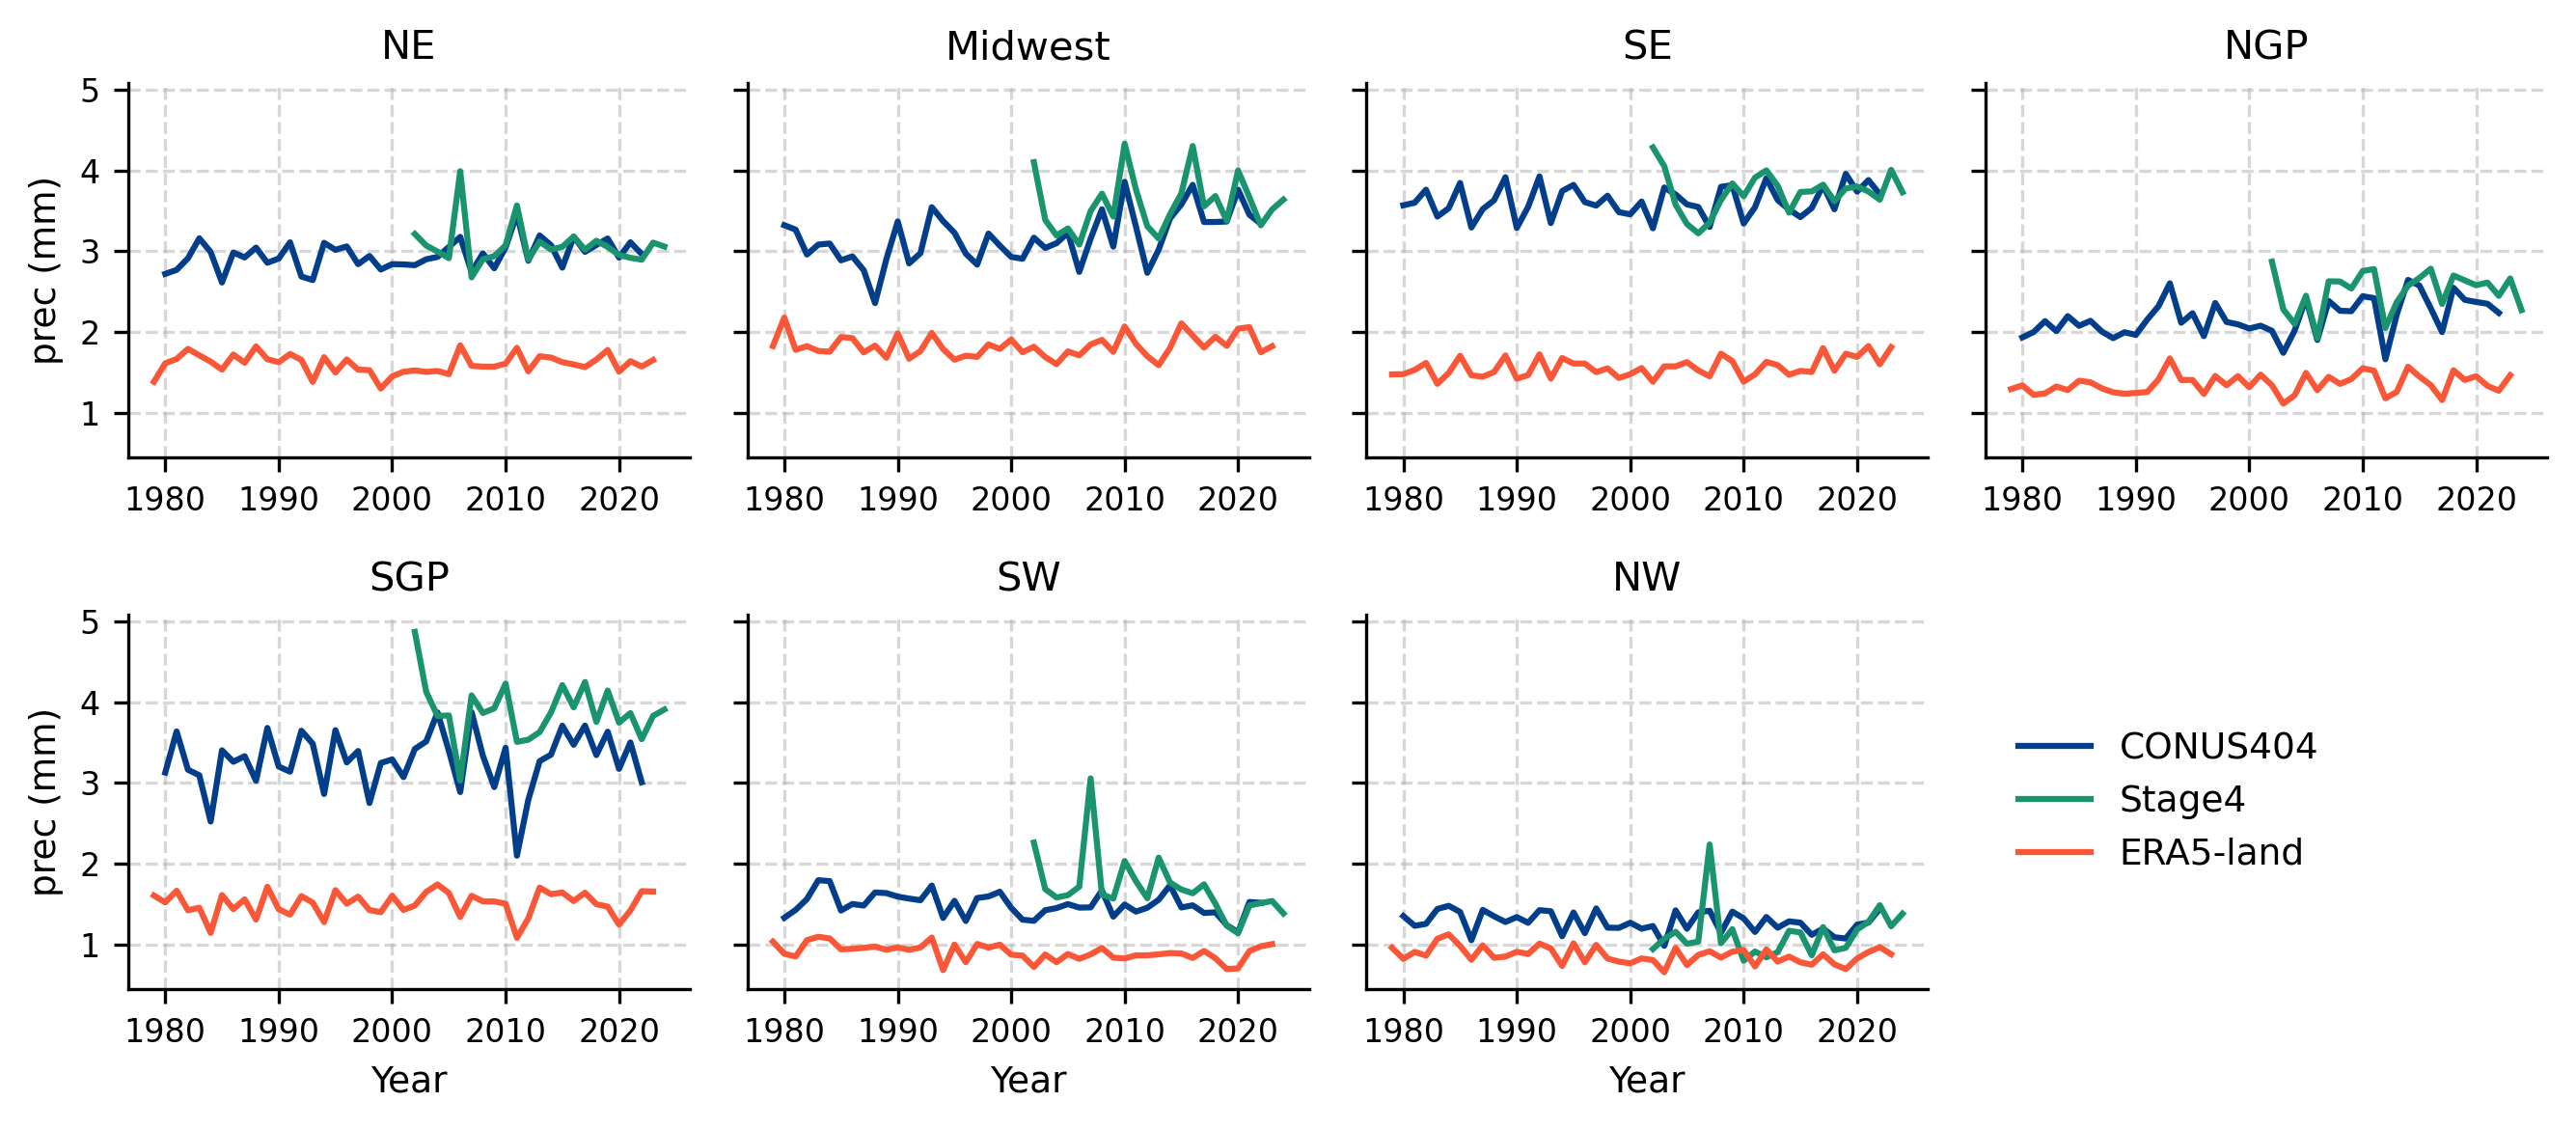

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

In [33]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_SPIIHhr_6_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_SPIIHhr_6_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_SPIIHhr_6_U*')

ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

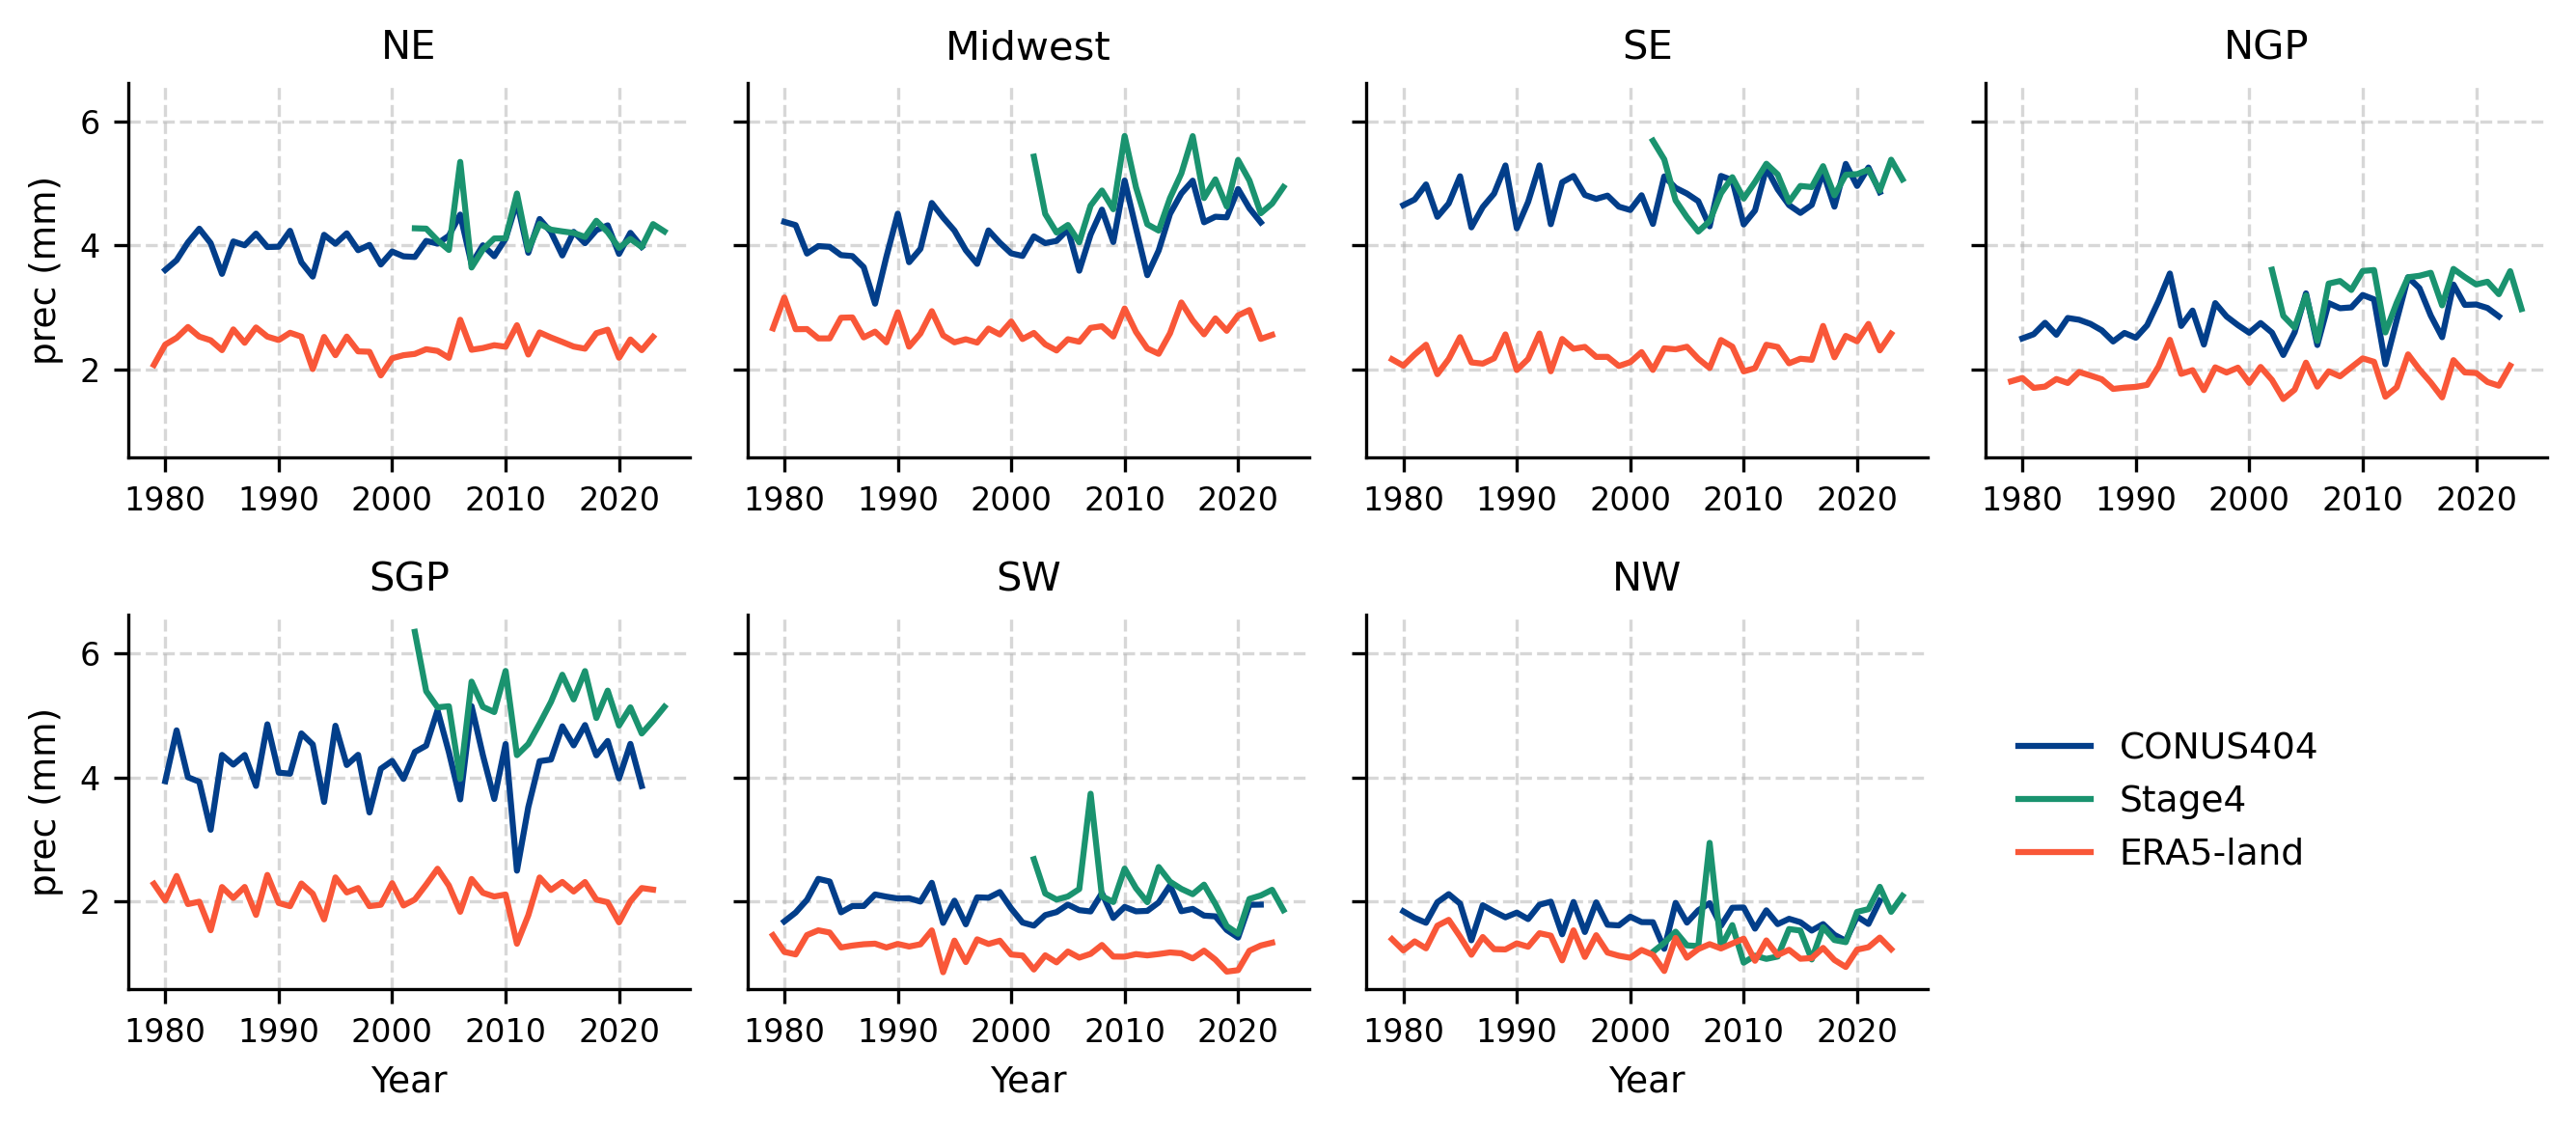

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

In [35]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_SPIIHhr_12_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_SPIIHhr_12_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_SPIIHhr_12_U*')

ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

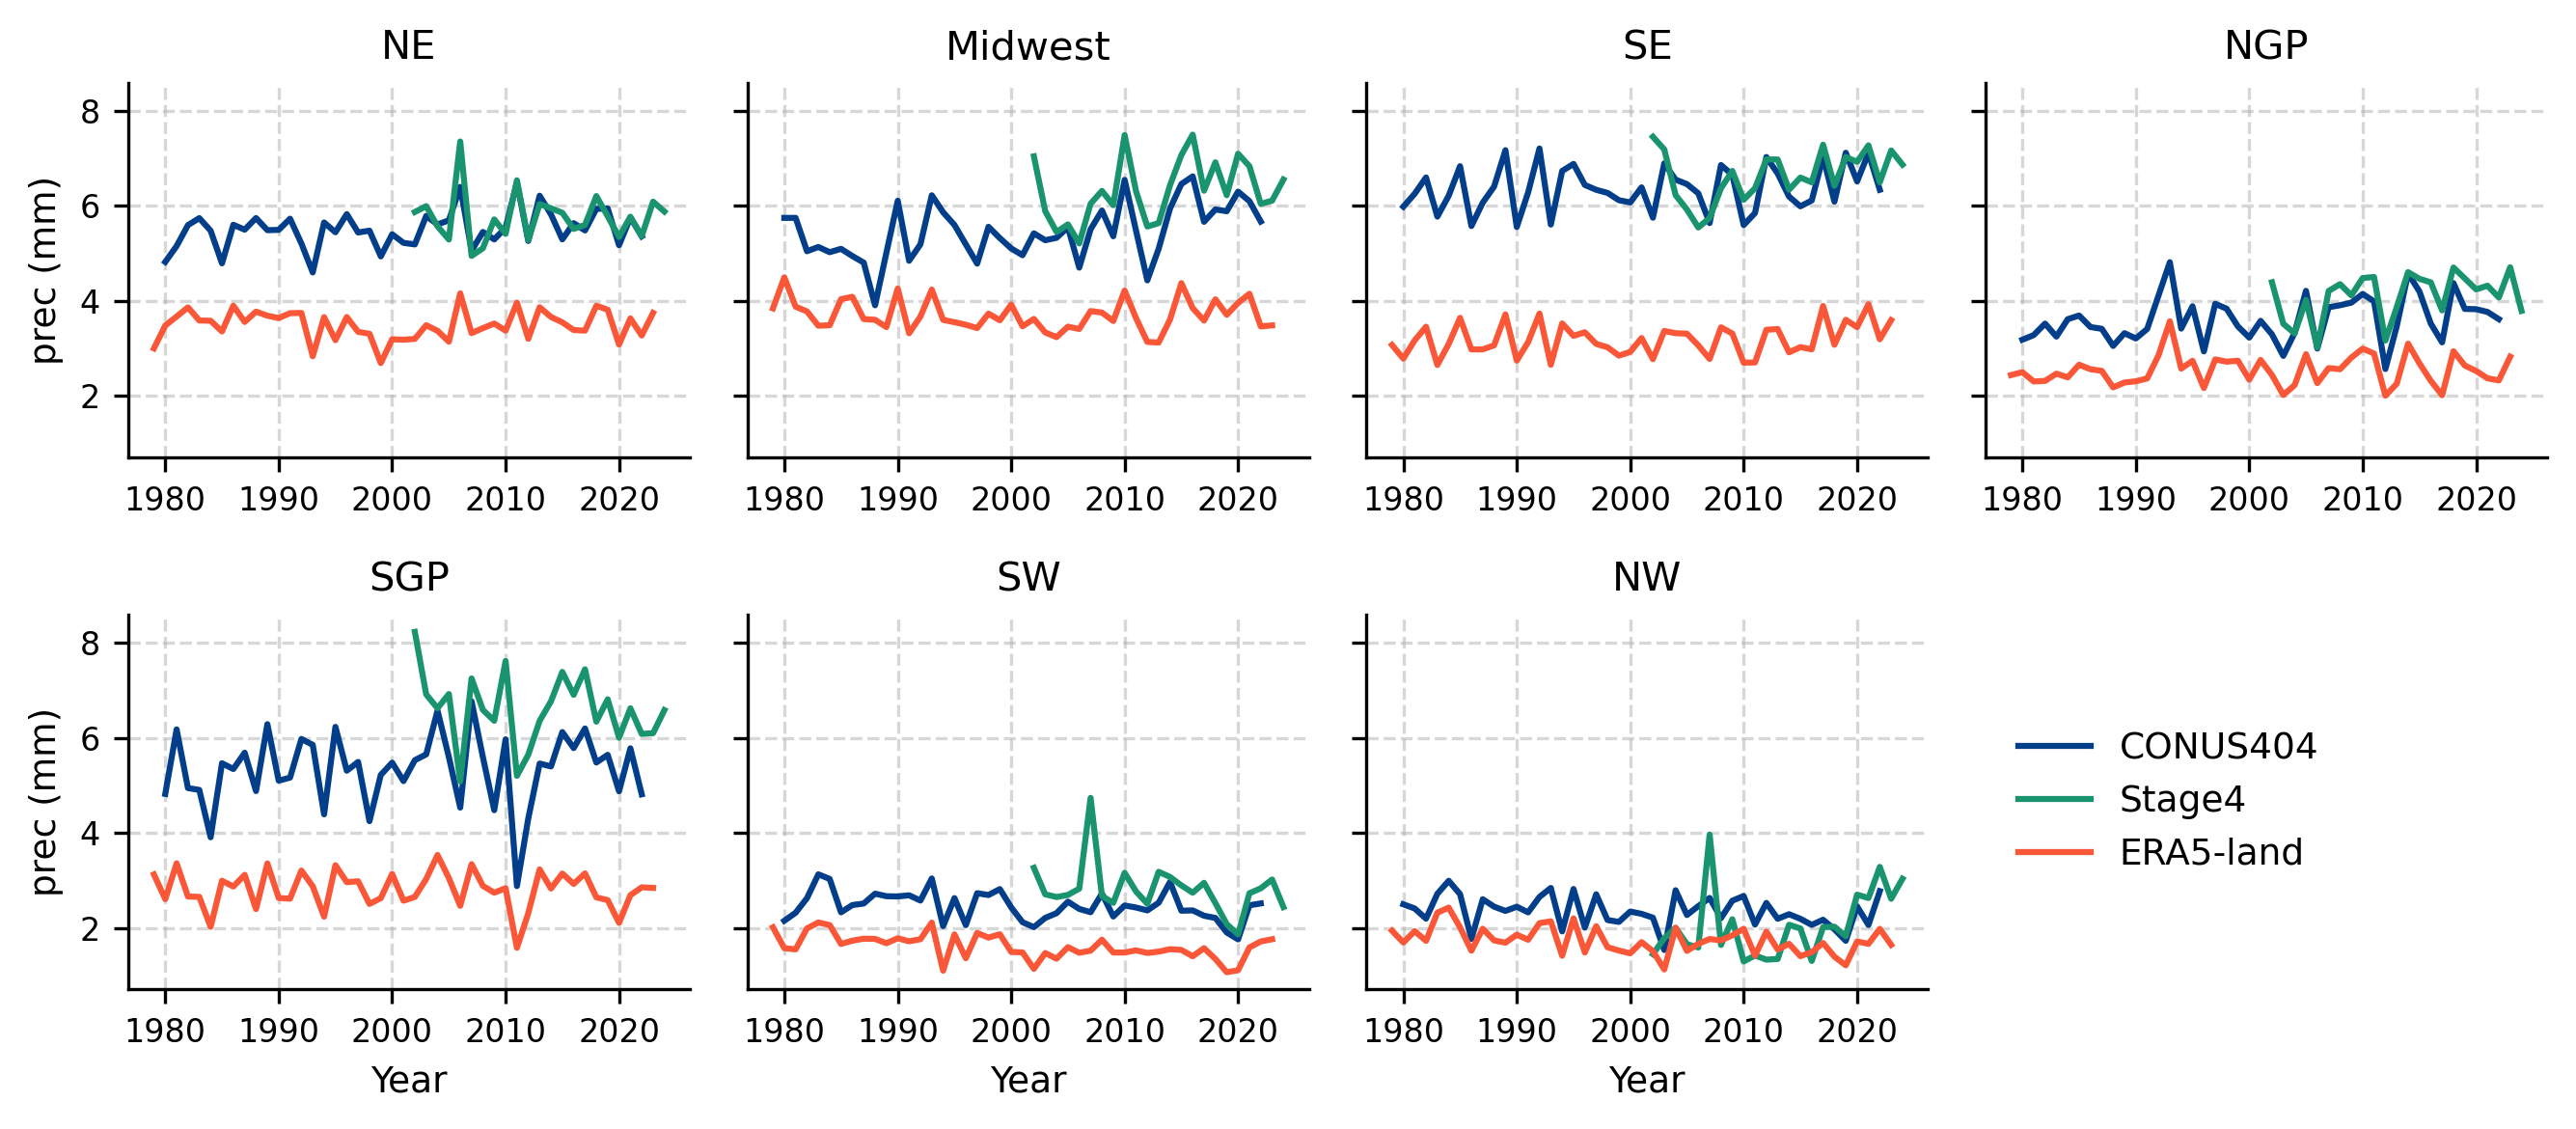

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

In [37]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_SPIIHhr_24_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_SPIIHhr_24_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_SPIIHhr_24_U*')

ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

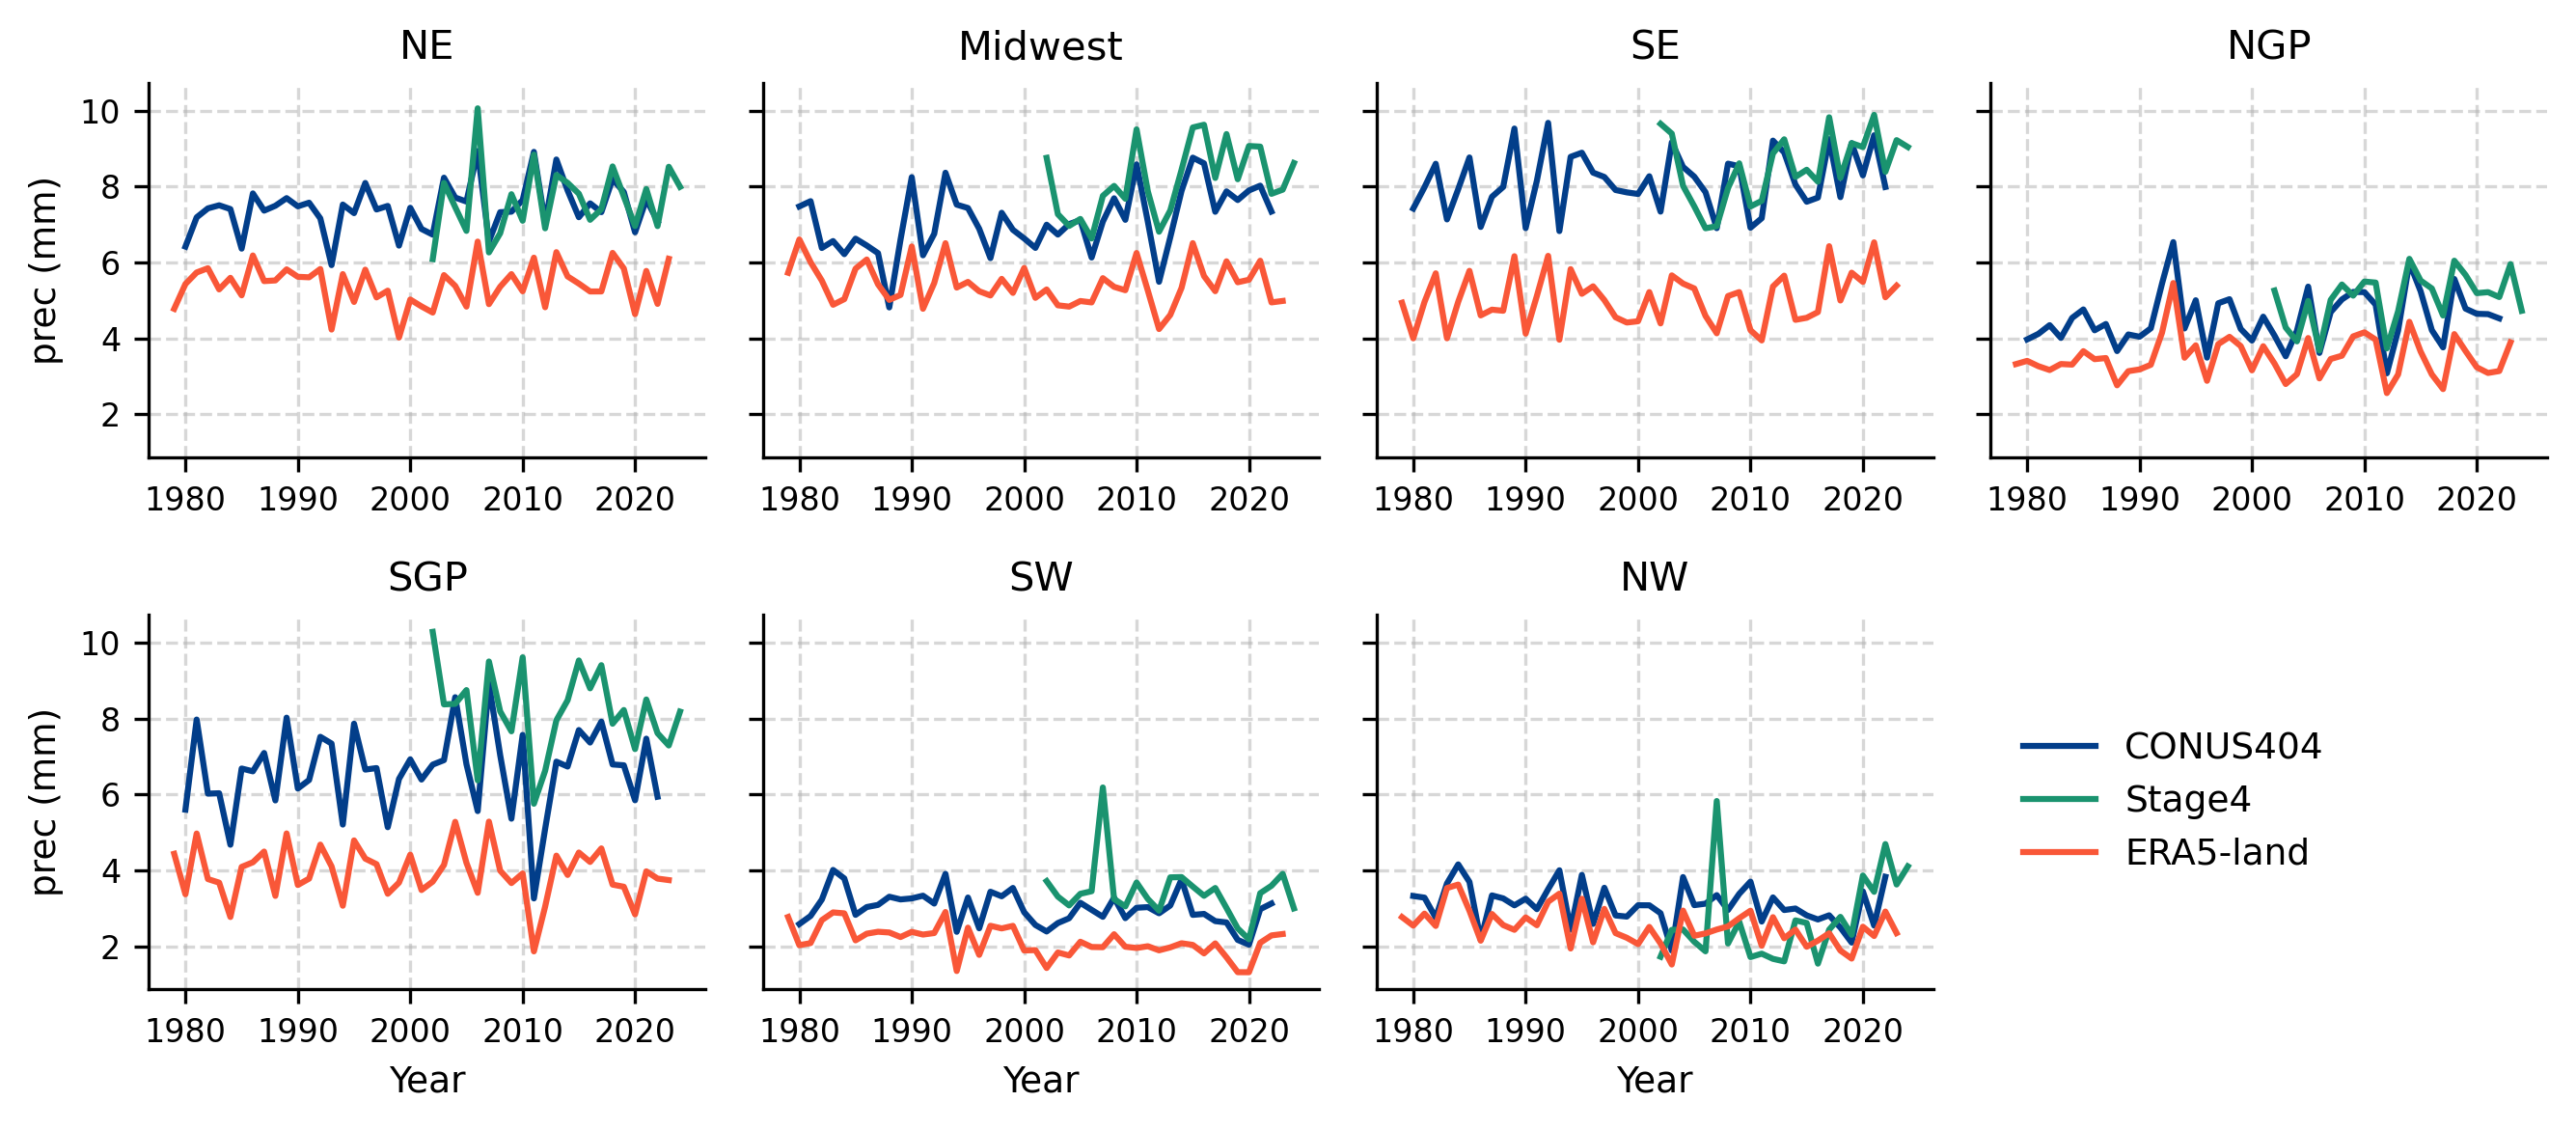

In [38]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

## Total precipitation

In [39]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_RTot_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_RTot_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_RTot_U*')

ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

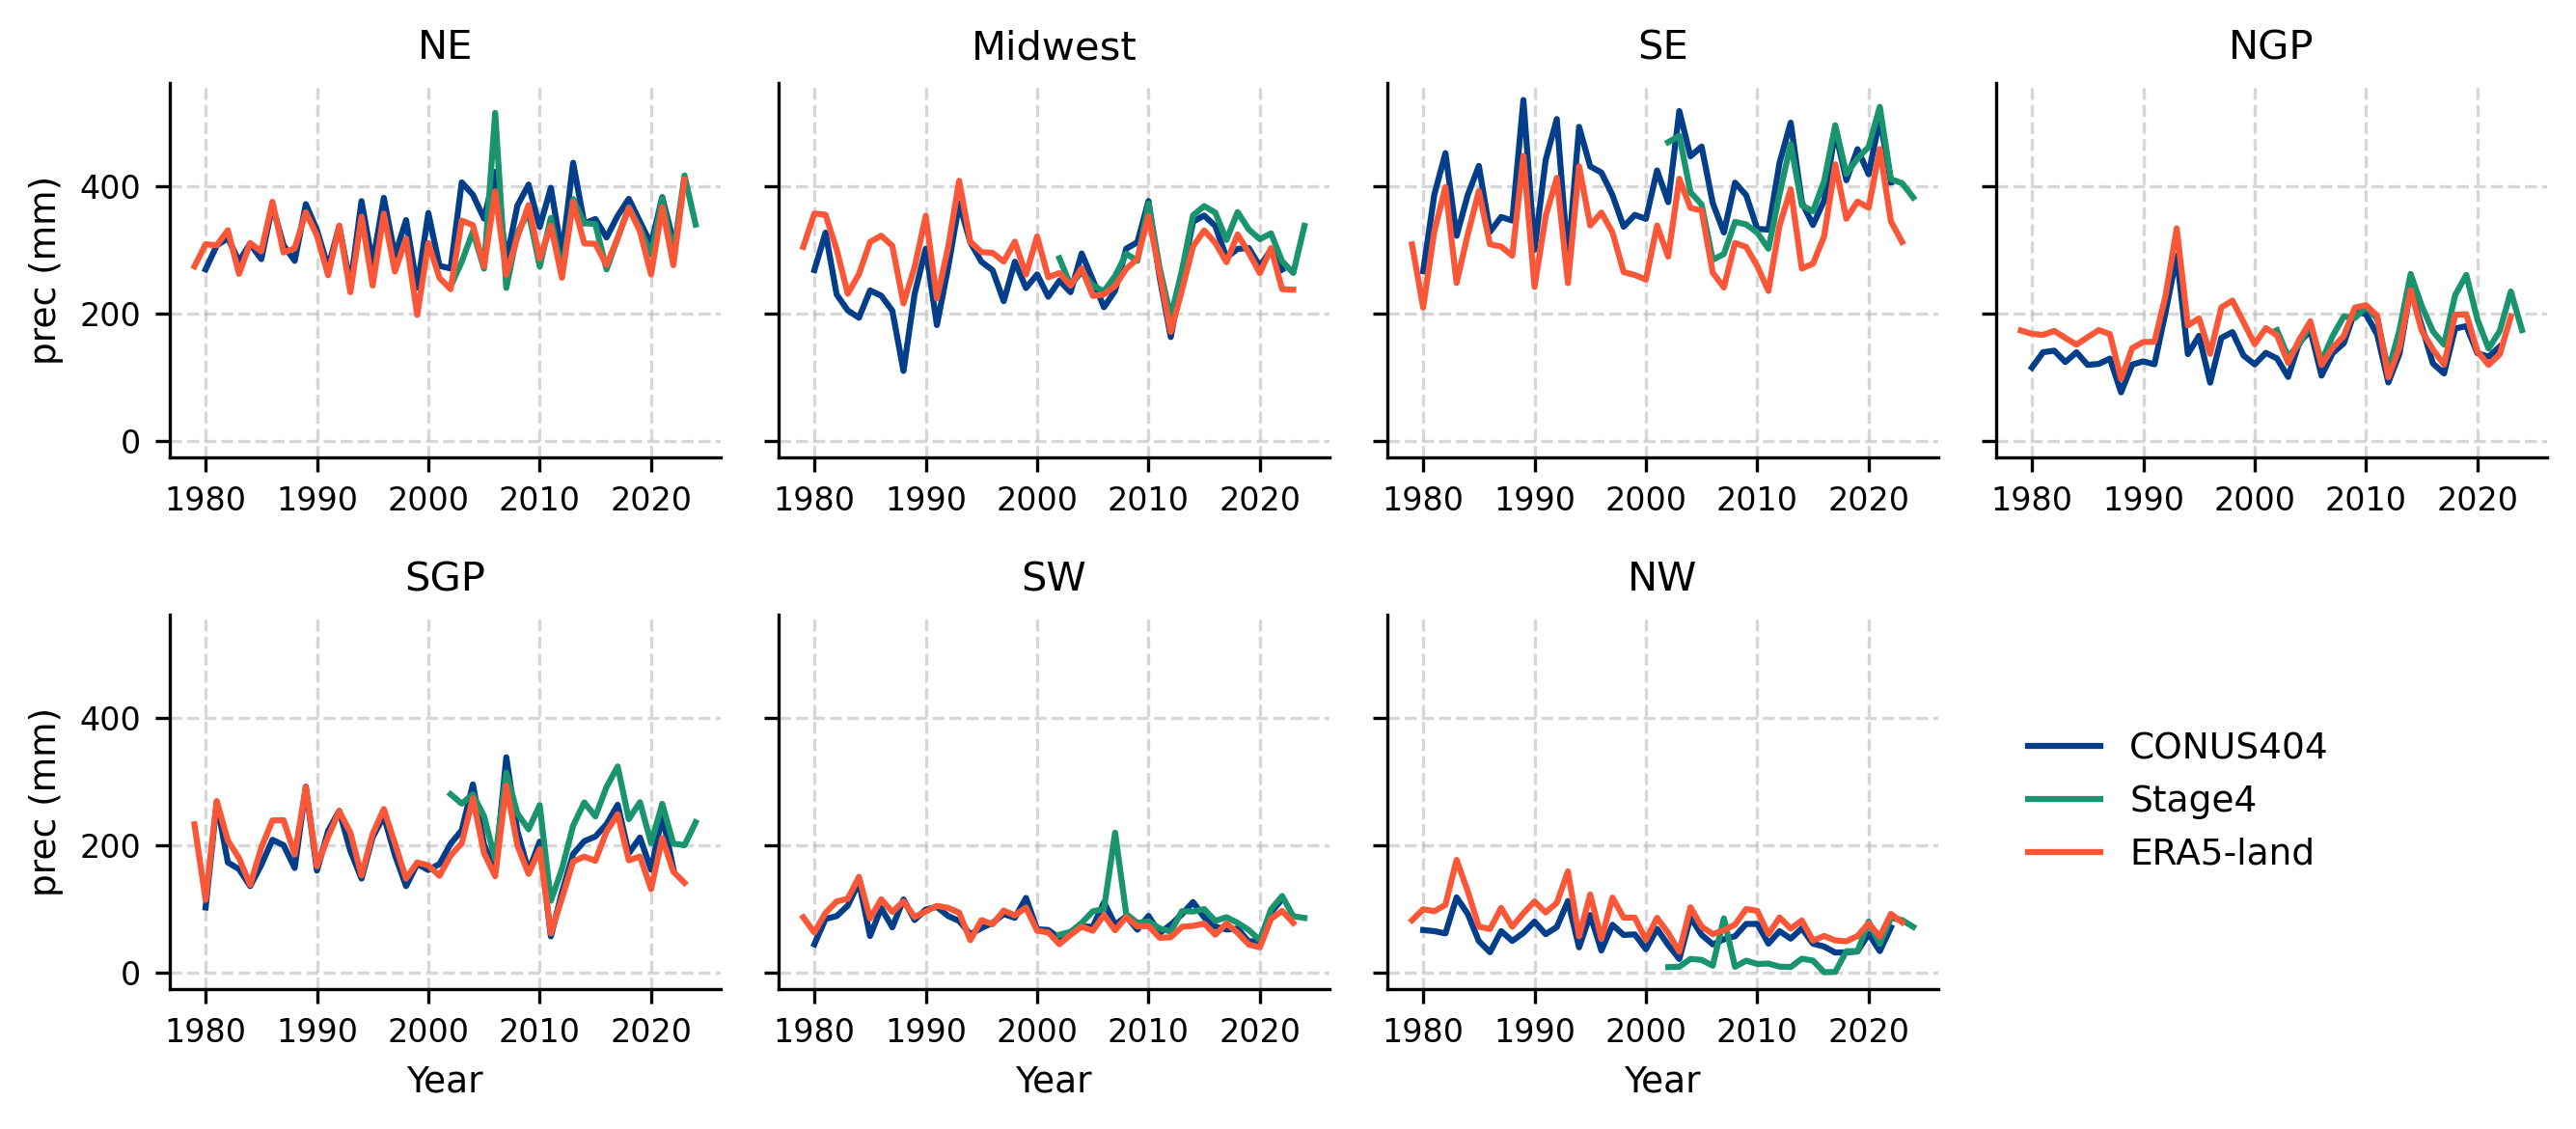

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['p'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('prec (mm)', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

## Percentage contribution to monthly, seasonal or annual totals from H-hour intervals exceeding the Qth (95th or 99th) wet-hour (w) percentiles (see RQpwHhr in Table 2)

In [43]:
ds_con = xr.open_mfdataset('/N/project/Zli_lab/gongg/CONUS404_data/prec_index/ds_percent_U*')
ds_sta = xr.open_mfdataset('/N/project/Zli_lab/gongg/stage4_data/prec_index/ds_percent_U*')
ds_era = xr.open_mfdataset('/N/project/Zli_lab/gongg/ERA_data/prec_index/ds_percent_U*')


ds_con_region = {}
ds_sta_region = {}
ds_era_region = {}

for r in regions:
    
    ds_con_region[r] = crop_xarray_to_region(ds_con, regions[r])
    ds_sta_region[r] = crop_xarray_to_region(ds_sta, regions[r])
    ds_era_region[r] = crop_xarray_to_region(ds_era, regions[r])

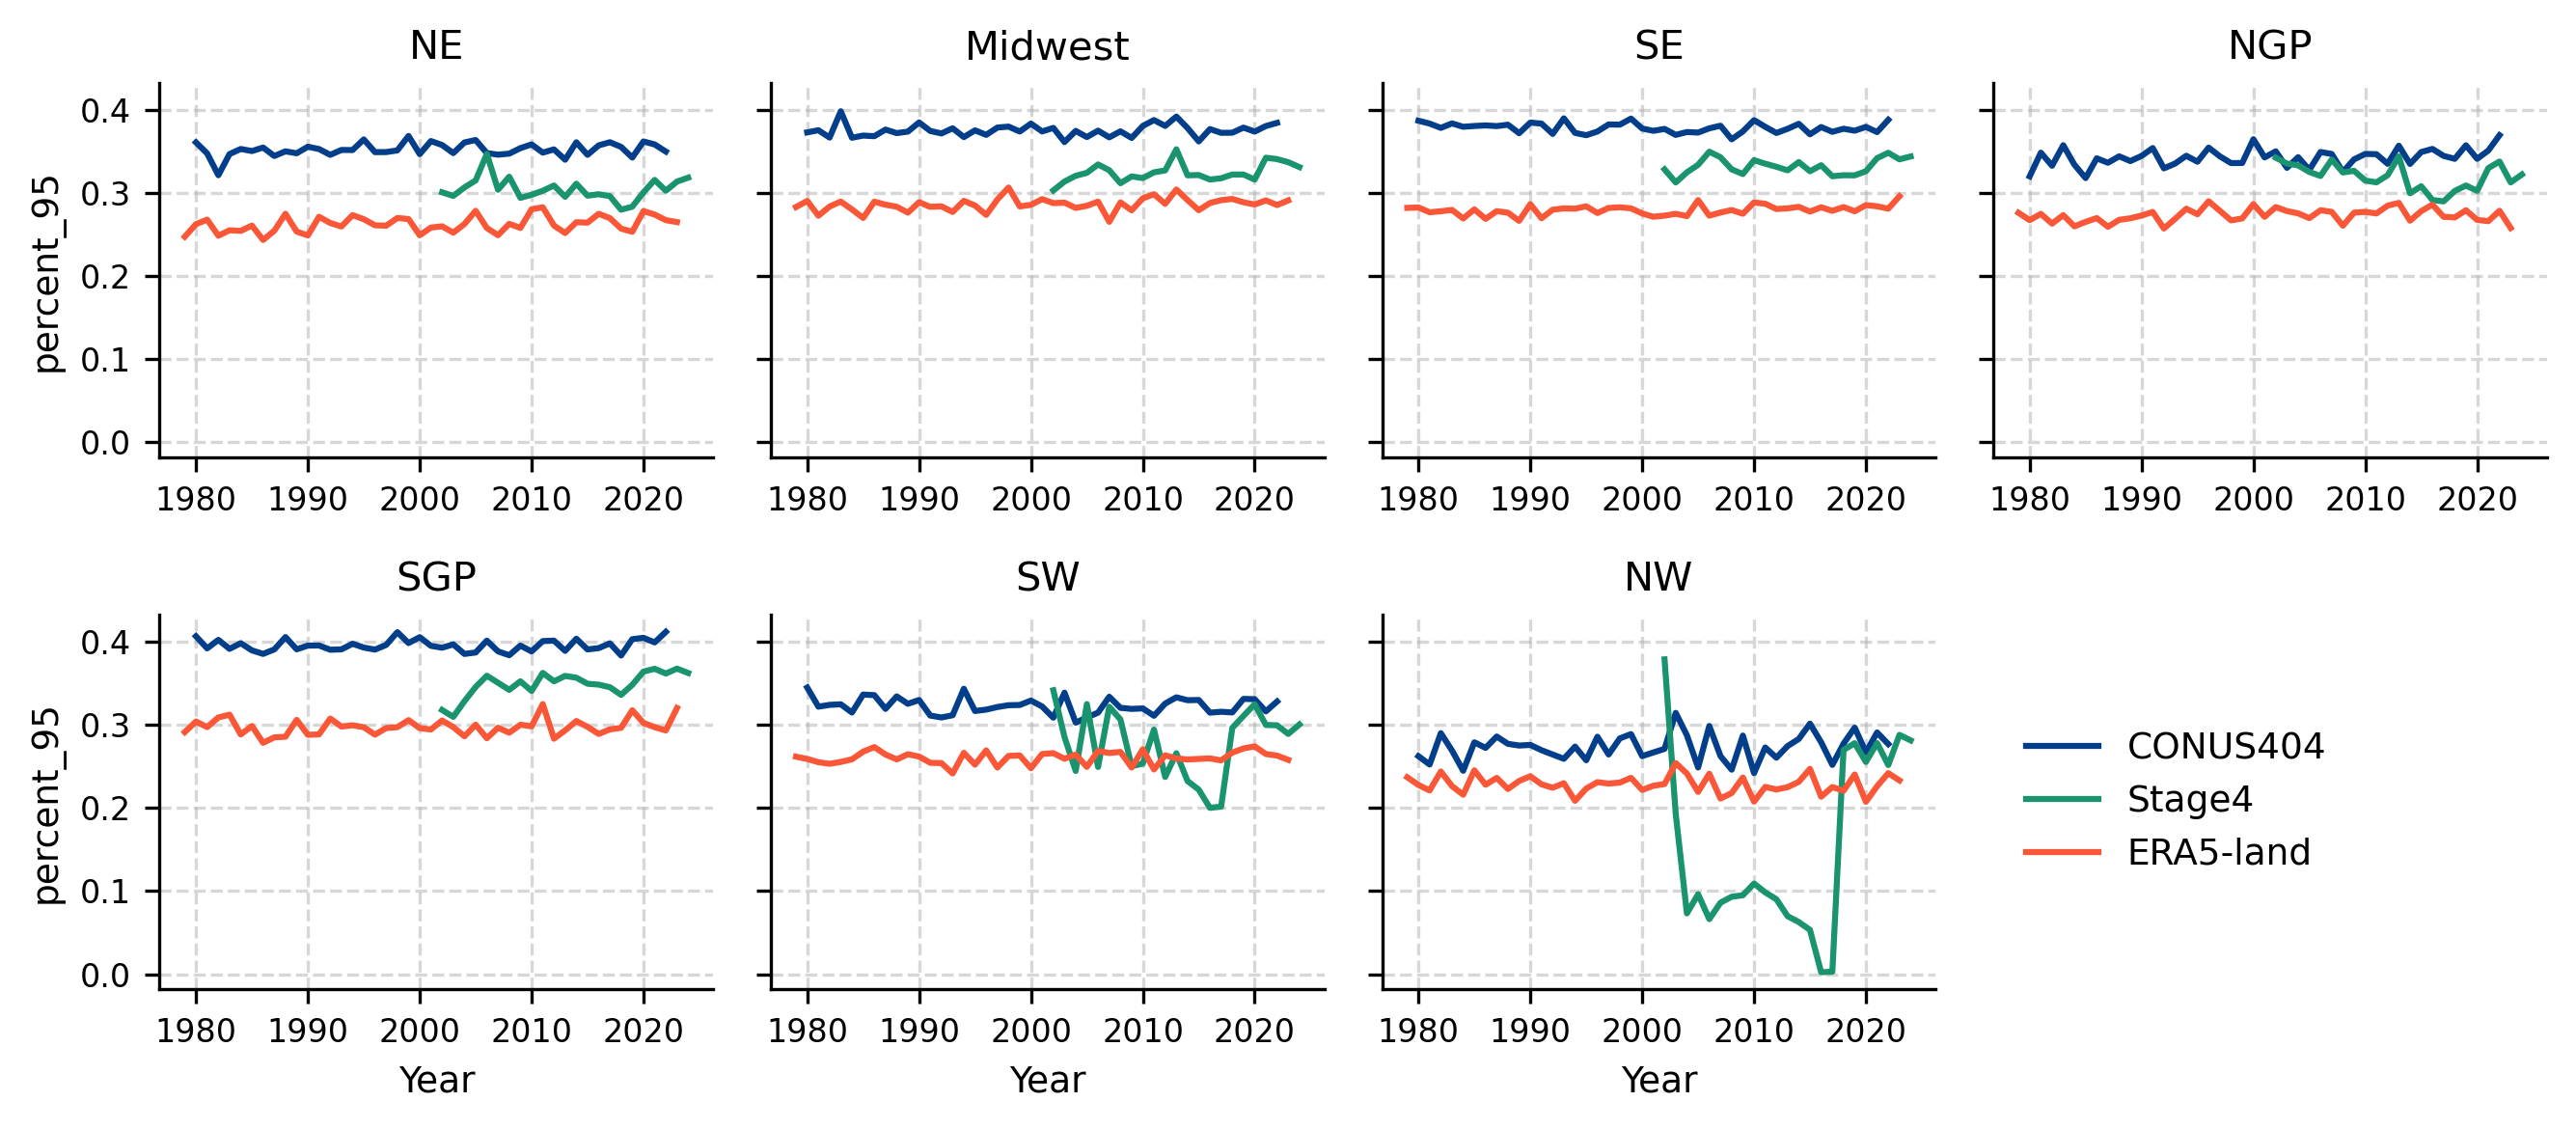

In [46]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['percent_95'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('percent_95', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

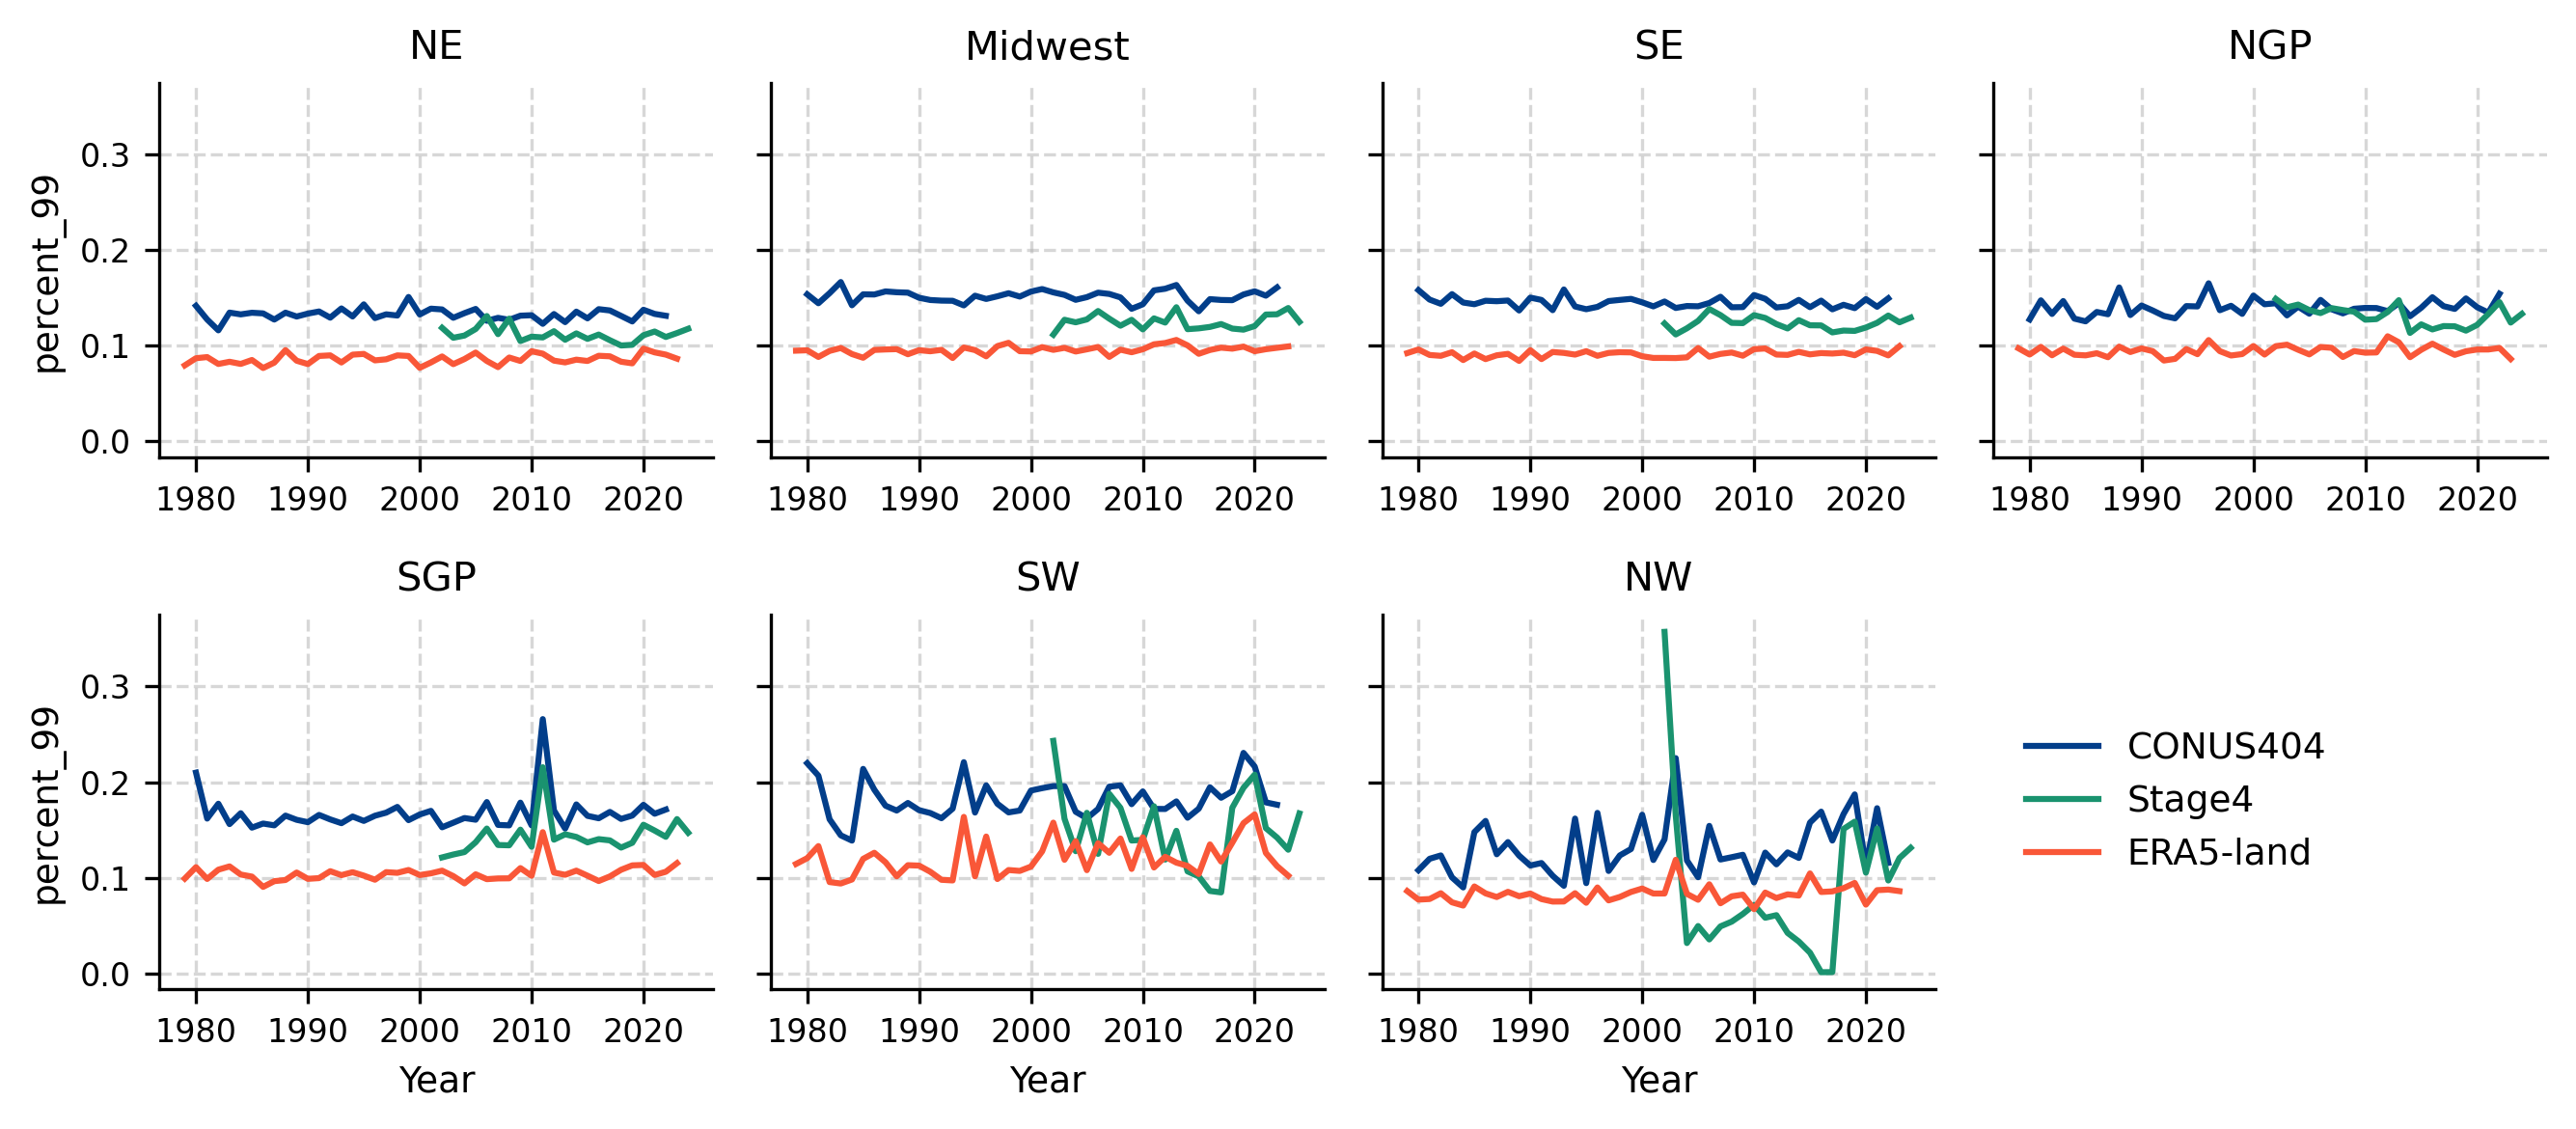

In [47]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4), dpi=dpi_, sharex=False, sharey=True)

regions_list = list(ds_con_region.keys())
datasets = {
    'con': ds_con_region,
    'sta': ds_sta_region,
    'era': ds_era_region
}
colors = {'con': '#023e8a', 'sta': '#1a936f', 'era': '#f95738'}
labels = {'con': 'CONUS404', 'sta': 'Stage4', 'era': 'ERA5-land'}

for i, region in enumerate(regions_list):
    ax = axes.flat[i]
    ax.set_title(region, fontsize=10)

    for key in datasets:
        ds = datasets[key][region]
        years = ds['year'].values
        mean_ts = ds['percent_99'].mean(dim=('lat', 'lon'))
        ax.plot(years, mean_ts, label=labels[key], color=colors[key])


    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i // 4 == 1:
        ax.set_xlabel('Year', fontsize=9)
    if i % 4 == 0:
        ax.set_ylabel('percent_99', fontsize=9)

ax8 = axes.flat[7]
ax8.axis('off')
handles = [Line2D([0], [0], color=colors[k], label=labels[k]) for k in datasets]
ax8.legend(handles=handles, loc='center left', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()